# COVID Predictions

In this short project, I aim to build a classification model that indicates whether a patient is at high risk due to covid or not. I will use a dataset from Kaggle, provided under a creative commons licence.

Note about this Jupyter Notebook

- In tackling this problem, I will employ a  workflow inspired from the workflow in Appendix A of the ["Hands-On Machine Learningwith Sci-kit Learn, Keras and Tensorflow", Third Edition by Aurelien Geron](https://www.oreilly.com/library/view/hands-on-machine-learning/9781098125967/)


## Workflow

This end-to-end Machine Learning Project employs the following workflow. To quickly navigate to the desired section, please click on the title of the section

0. [Frame the problem](#section0)


1. [Inspect and Clean the Data](#section1)

<ul>

- [Get the Data](#section1_0) </li>
- [Data Profiling](#section1_1) </li>
- [Bringing Missing Values to a Consistent Format](#section1_2) </li>
- [Examining Missing Values](#section1_3) </li>
- [Missing Values Correlation](#section1_4) </li>
- [Dealing with Missing Values](#section1_5) </li>
- [Clean Data Visualization](#section1_6) </li>

</ul>

2. [Split the Data](#section2)

<ul>


- [Train/Test](#section2_2) </li>

</ul>

3. [Explore the Data](#section3)


<ul>

- [Looking for Correlations](#section3_1)
- [Experimenting with Transformation](#section3_2)

</ul>

4. [Pre-process Data for Machine Learning Algorithms](#section4)

<ul>

- [Built Pre-processing Pipeline](#section4_1)
- [Evaluation Metric](#section4_2)
- [Create New Variables for Evaluation](#section4_3)

</ul>

5. [Select and train models](#section5)

<ul>

- [Dummy Classifier](#section5_1)
- [SGD Classifier](#section5_2)
- [RandomForest Classifier](#section5_3)
- [Logistic Regression](#section5_4)
- [Nearest Neighbours Classifier](#section5_5)
- [Multi Layer Perceptron](#section5_6)
- [XGBoost](#section5_7)


</ul>

6. [Voting Classifier](#section6)

<ul>

- [Soft Voting](#section6_1)


</ul>


7. [Undersampling methods](#section7)

- [Random Undersampling](#section7_1)
- [Near Miss](#section7_2)

8. [Oversampling methods](#section8)

- [SMOTE](#section8_1)
- [Random Oversampling](#section8_2)
- [Borderline-SMOTE1](#section8_3)

9. [Generalization Errors of Best Model](#section9)

<ul>

- [Get Final Predictions](#section9_1)
- [MAE](#section9_2)
- [Confusion Matrix](#section9_3)
- [Accuracy](#section9_4)
</ul>


10. [Launch](#section10)





# <a id='section0'></a>0. Frame the problem

The goal is to develop a predictive model for COVID-19 high risk patients based on historical data. As the fraction of high risk patients is definitely outnumbered by the fraction of patients with lower risk, the dataset is highly imbalanced. I will attempt to find a modelling approach that (i) gives a specified cut-off for high-risk patients and (ii) returns a probability model together with a confidence interval that a patient is at high risk. For the high risk class, it is extremely important to have recall as close to 1 as possible.

<p> The decision will be based only on the variables provided in this dataset, such that, if new data becomes available or different data is fed the model can be externally validated. An evaluation function consisisting of several metrics will be used to internally validate the model. After cleaning the data, I will make training/test set splits for evaluation. After testing many models on the validation set, the best one (the model that gives best performance in terms of its generalization error) will be selected . Finally, some conclusions and interpretation of results will be offered with this notebook. </p>

The data can be found at [Kaggle](https://www.kaggle.com/datasets/meirnizri/covid19-dataset/)

According to Kaggle : "The raw dataset consists of 21 different features and 1,048,576 unique patients. In the Boolean features, 1 means "yes" and 2 means "no". values as 97 and 99 are missing data."

Info about the dataset, including a dictionary is given [here](https://www.kaggle.com/datasets/meirnizri/covid19-dataset/)

For ease of access, I reproduce it below :

"The dataset was provided by the Mexican government (link). This dataset contains an enormous number of anonymized patient-related information including pre-conditions. The raw dataset consists of 21 unique features and 1,048,576 unique patients. In the Boolean features, 1 means "yes" and 2 means "no". values as 97 and 99 are missing data.

- sex: 1 for female and 2 for male.
- age: of the patient.
- classification: covid test findings. Values 1-3 mean that the patient was diagnosed with covid in different
-degrees. 4 or higher means that the patient is not a carrier of covid or that the test is inconclusive.
- patient type: type of care the patient received in the unit. 1 for returned home and 2 for hospitalization.
- pneumonia: whether the patient already have air sacs inflammation or not.
- pregnancy: whether the patient is pregnant or not.
- diabetes: whether the patient has diabetes or not.
- copd: Indicates whether the patient has Chronic obstructive pulmonary disease or not.
- asthma: whether the patient has asthma or not.
- inmsupr: whether the patient is immunosuppressed or not.
- hypertension: whether the patient has hypertension or not.
- cardiovascular: whether the patient has heart or blood vessels related disease.
- renal chronic: whether the patient has chronic renal disease or not.
- other disease: whether the patient has other disease or not.
- obesity: whether the patient is obese or not.
- tobacco: whether the patient is a tobacco user.
- usmr: Indicates whether the patient treated medical units of the first, second or third level.
- medical unit: type of institution of the National Health System that provided the care.
- intubed: whether the patient was connected to the ventilator.
- icu: Indicates whether the patient had been admitted to an Intensive Care Unit.
- date died: If the patient died indicate the date of death, and 9999-99-99 otherwise."

Before proceeding further, let's import the necessary libraries for data manipulation and visualization, together with an automatic EDA tool : ydata_profiling

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from ydata_profiling import ProfileReport
%matplotlib inline


# <a id='section1'></a>1. Inspect and Clean the Data

## <a id='section1_0'></a>Get the Data

I will use the data from Kaggle (it can be found in the link at the top of this notebook). But first, I will write a function that download the data directly from there.

In [2]:
import os
from kaggle.api.kaggle_api_extended import KaggleApi

def download_kaggle_dataset(dataset):
    api = KaggleApi()
    api.authenticate()

    ## Create a directory to store the data
    os.makedirs('kaggle_covid_data', exist_ok=True)

    ## Download the dataset
    api.dataset_download_files(dataset, path='kaggle_covid_data', unzip=True)

## Use the function defined above to download the dataset
## It is sufficient to use the dataset identifier found in the dataset URL
download_kaggle_dataset('meirnizri/covid19-dataset/')

We upload the data into a dataframe

In [3]:
covid_df = pd.read_csv('kaggle_covid_data/Covid Data.csv')

Let's create a copy of the data, to preserve the original dataframe in case it is needed later for comparison.

In [4]:
covid = covid_df.copy()

Let us have a quick look at the data

In [5]:
## display key information about the dataset
print(covid.info())
print(covid.shape)
covid.head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048575 entries, 0 to 1048574
Data columns (total 21 columns):
 #   Column                Non-Null Count    Dtype 
---  ------                --------------    ----- 
 0   USMER                 1048575 non-null  int64 
 1   MEDICAL_UNIT          1048575 non-null  int64 
 2   SEX                   1048575 non-null  int64 
 3   PATIENT_TYPE          1048575 non-null  int64 
 4   DATE_DIED             1048575 non-null  object
 5   INTUBED               1048575 non-null  int64 
 6   PNEUMONIA             1048575 non-null  int64 
 7   AGE                   1048575 non-null  int64 
 8   PREGNANT              1048575 non-null  int64 
 9   DIABETES              1048575 non-null  int64 
 10  COPD                  1048575 non-null  int64 
 11  ASTHMA                1048575 non-null  int64 
 12  INMSUPR               1048575 non-null  int64 
 13  HIPERTENSION          1048575 non-null  int64 
 14  OTHER_DISEASE         1048575 non-null  int64 
 15

USMER  MEDICAL_UNIT  SEX  PATIENT_TYPE   DATE_DIED  INTUBED  PNEUMONIA  \
0      2             1    1             1  03/05/2020       97          1   
1      2             1    2             1  03/06/2020       97          1   
2      2             1    2             2  09/06/2020        1          2   
3      2             1    1             1  12/06/2020       97          2   
4      2             1    2             1  21/06/2020       97          2   
5      2             1    1             2  9999-99-99        2          1   
6      2             1    1             1  9999-99-99       97          2   
7      2             1    1             1  9999-99-99       97          1   
8      2             1    1             2  9999-99-99        2          2   
9      2             1    1             2  9999-99-99        2          2   

   AGE  PREGNANT  DIABETES  ...  ASTHMA  INMSUPR  HIPERTENSION  OTHER_DISEASE  \
0   65         2         2  ...       2        2             1              2   
1   72        97         2  ...       2        2             1              2   
2   55        97         1  ...       2        2             2              2   
3   53         2         2  ...       2        2             2              2   
4   68        97         1  ...       2        2             1              2   
5   40         2         2  ...       2        2             2              2   
6   64         2         2  ...       2        2             2              2   
7   64         2         1  ...       2        1             1              2   
8   37         2         1  ...       2        2             1              2   
9   25         2         2  ...       2        2             2              2   

   CARDIOVASCULAR  OBESITY  RENAL_CHRONIC  TOBACCO  CLASIFFICATION_FINAL  ICU  
0               2        2              2        2                     3   97  
1               2        1              1        2                     5   97  
2               2        2              2        2                     3    2  
3               2        2              2        2                     7   97  
4               2        2              2        2                     3   97  
5               2        2              2        2                     3    2  
6               2        2              2        2                     3   97  
7               2        2              1        2                     3   97  
8               2        1              2        2                     3    2  
9               2        2              2        2                     3    2  

[10 rows x 21 columns]

In [6]:
## columns of the dataset
print(covid.columns)

Index(['USMER', 'MEDICAL_UNIT', 'SEX', 'PATIENT_TYPE', 'DATE_DIED', 'INTUBED',
       'PNEUMONIA', 'AGE', 'PREGNANT', 'DIABETES', 'COPD', 'ASTHMA', 'INMSUPR',
       'HIPERTENSION', 'OTHER_DISEASE', 'CARDIOVASCULAR', 'OBESITY',
       'RENAL_CHRONIC', 'TOBACCO', 'CLASIFFICATION_FINAL', 'ICU'],
      dtype='object')


Note: There are 1048575 observations (rows) and 21 columns

Are there any null values? Let's further investigate this in order to find a way to deal with them. This is because Machine Learning models to not handle well missing (NaN) values.

In [7]:
##this shows the data types of the columns
covid.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048575 entries, 0 to 1048574
Data columns (total 21 columns):
 #   Column                Non-Null Count    Dtype 
---  ------                --------------    ----- 
 0   USMER                 1048575 non-null  int64 
 1   MEDICAL_UNIT          1048575 non-null  int64 
 2   SEX                   1048575 non-null  int64 
 3   PATIENT_TYPE          1048575 non-null  int64 
 4   DATE_DIED             1048575 non-null  object
 5   INTUBED               1048575 non-null  int64 
 6   PNEUMONIA             1048575 non-null  int64 
 7   AGE                   1048575 non-null  int64 
 8   PREGNANT              1048575 non-null  int64 
 9   DIABETES              1048575 non-null  int64 
 10  COPD                  1048575 non-null  int64 
 11  ASTHMA                1048575 non-null  int64 
 12  INMSUPR               1048575 non-null  int64 
 13  HIPERTENSION          1048575 non-null  int64 
 14  OTHER_DISEASE         1048575 non-null  int64 
 15

In [8]:
covid_isnull = covid.isnull().sum()
covid_isnull

USMER                   0
MEDICAL_UNIT            0
SEX                     0
PATIENT_TYPE            0
DATE_DIED               0
INTUBED                 0
PNEUMONIA               0
AGE                     0
PREGNANT                0
DIABETES                0
COPD                    0
ASTHMA                  0
INMSUPR                 0
HIPERTENSION            0
OTHER_DISEASE           0
CARDIOVASCULAR          0
OBESITY                 0
RENAL_CHRONIC           0
TOBACCO                 0
CLASIFFICATION_FINAL    0
ICU                     0
dtype: int64

## <a id='section1_1'></a>Data Profiling

There are no null values. We can run a profile report to see any interesting trends in the data

In [9]:
html_report = ProfileReport(covid)
html_report.to_file(output_file='covid_data.html')

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

In [10]:
html_report

**Observations on Profile Report:**

- We have 5.3% duplicate rows
- Several categorical columns are highly imbalanced
- There are no null values, but missing values are marked as 98, 99
- We have "1" for positive and "2" for negative (with other numbers signifying no data)
- The Age of the patient closely resembles a normal distribution
- Pregnancy status is largely missing
- There is a relatively small number of missing observations regarding comorbidity : diabetes, copd, asthma etc
- Classification Final (according to the dictionary) shows covid status; for our purposes, I must create new, well-defined categories based on the data in this column that will serve as targets and inform of the severity of covid
- Apparently, there are high correlations between columns indicating diseases
- There are 55672 duplicate rows ( approx 5.3%) : these provide no value and must be eliminated from the dataframe


In the following, I will start cleaning the data. After the data is clean, I can create a test set and a validation set right away and begin experimenting on the training set. The succesfull transformations will be integrated into a pipeline and applied to the data - this is to ensure the data is ready to be fed to any ML model. For exploration, I will create a copy of the data. Once the final pipeline is made, it will be applied on any covid data.

The plan for the cleaning is:

- replace "2" with "0" and any other numbers in categorical numbers with NaN : please note that encoding "no" as 0 instead of "2" is a personal choice meant to increase interpretability of the data
- clarify male/female categories : I will create explicit categories showing the sex of the patient
- drop duplicates


## <a id='section1_2'></a>Bring Missing Values to a Consistent Format

In [11]:
covid.columns

Index(['USMER', 'MEDICAL_UNIT', 'SEX', 'PATIENT_TYPE', 'DATE_DIED', 'INTUBED',
       'PNEUMONIA', 'AGE', 'PREGNANT', 'DIABETES', 'COPD', 'ASTHMA', 'INMSUPR',
       'HIPERTENSION', 'OTHER_DISEASE', 'CARDIOVASCULAR', 'OBESITY',
       'RENAL_CHRONIC', 'TOBACCO', 'CLASIFFICATION_FINAL', 'ICU'],
      dtype='object')

As a first step, let us replace the "2" with "0", so the columns can become one-hot encoded

In [12]:
##replace "2" with 0 in categorical columns that show the presence of a symptom
covid['USMER'].replace(2,0, inplace=True)
covid['INTUBED'].replace(2,0, inplace=True)
covid['PNEUMONIA'].replace(2,0, inplace=True)
covid['DIABETES'].replace(2,0, inplace=True)
covid['COPD'].replace(2,0, inplace=True)
covid['ASTHMA'].replace(2,0, inplace=True)
covid['INMSUPR'].replace(2,0, inplace=True)
covid['HIPERTENSION'].replace(2,0, inplace=True)
covid['OTHER_DISEASE'].replace(2,0, inplace=True)
covid['CARDIOVASCULAR'].replace(2,0, inplace=True)
covid['OBESITY'].replace(2,0, inplace=True)
covid['RENAL_CHRONIC'].replace(2,0, inplace=True)
covid['TOBACCO'].replace(2,0, inplace=True)
covid['ICU'].replace(2,0, inplace=True)
covid['PREGNANT'].replace(2,0, inplace=True)



Let's replace the sex with Male(2) or Female(1)

In [13]:
covid["SEX"] = covid['SEX'].astype('string')
covid['SEX'].replace({"1": 'Female', "2": 'Male'}, inplace=True)

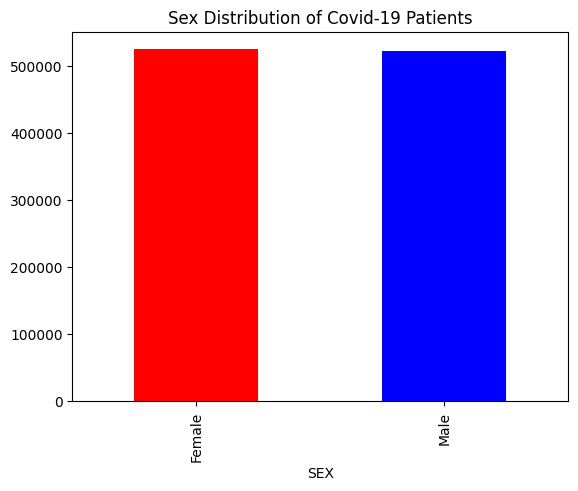

In [14]:
covid["SEX"].value_counts().plot(kind='bar', color=['red', 'blue'])
plt.title("Sex Distribution of Covid-19 Patients")
plt.show()

Observe: 

- we have succesfully replaced the two distributions with "Male" and "Female"
- the distributions are roughly equal, so there is no sex that is less affected


Let's also make it clear if the patient was sent home(1) or hospitalized(2)

In [15]:
covid["PATIENT_TYPE"] = covid['PATIENT_TYPE'].astype('string')
covid['PATIENT_TYPE'].replace({"1": 'Home', "2": 'Hospital'}, inplace=True)

To understand how severe a particular covid case was, it is very important to understand if the patient died or not. Let us create two columns that one-hot encode whether the patient passed away

In [16]:
covid["Lower_Risk"] = covid["DATE_DIED"].apply(lambda x: 1 if x == "9999-99-99" else 0)
covid["Higher_Risk"] = covid["DATE_DIED"].apply(lambda x: 1 if x != "9999-99-99" else 0)


Observe: Based on whether the patients died or survived, I chose to encode the patients as "Higher_Risk" or "Lower_Risk". The ratinale is that we can infer the patients who were at high_risk based on the information on whether they survived or not.

Finally, let us get rid of missing data. Instead of 97 or 98 in our categorical columns, let us fill the values with NaN. Then, based on the number of NaN and the underlying distributions, let's make decisions on how to deal with them.

In [17]:
covid.replace({97: np.nan, 98: np.nan, 99: np.nan}, inplace=True)

Now, let us see how many NaN (null) values we have for each row and decide the best strategy to deal with them

In [18]:
covid.isnull().sum()

USMER                        0
MEDICAL_UNIT                 0
SEX                          0
PATIENT_TYPE                 0
DATE_DIED                    0
INTUBED                 855869
PNEUMONIA                16003
AGE                        345
PREGNANT                527265
DIABETES                  3338
COPD                      3003
ASTHMA                    2979
INMSUPR                   3404
HIPERTENSION              3104
OTHER_DISEASE             5045
CARDIOVASCULAR            3076
OBESITY                   3032
RENAL_CHRONIC             3006
TOBACCO                   3220
CLASIFFICATION_FINAL         0
ICU                     856032
Lower_Risk                   0
Higher_Risk                  0
dtype: int64

Observe:

- The "INTUBED" and "ICU" and "PREGNANT" have over 80% missing values; they do follow the distributions observed in the EDA
- For the remaining columns we have at most 0.5% null values. 
- there are multiple options for dealling with missing data

## <a id='section1_3'></a>Examining Missing Data

The first step in dealing with missing data, is to _understand if there is a pattern_. Data may be missing at random (for example, due to imputation errors) or it might be connected to the other observations. For example, a missing entry for "INTUBED" may also be accompanied by a missing entry in "ICU". The data for "PREGNANT" should necessarily be correlated with the category "FEMALE". In any case,  any particular imputation method should be informed by the data. The strategy to do this is as follows:

1. Look at the distributions of the features with missing and understand if there is any patterns that emerge
2. Use a _missingness_ correlation. This indicates whether missing data in one column predicts the existence of missing data in another column

Information on the missingno library that provides a small toolset for understanding and visualizing data can be found at : https://github.com/ResidentMario/missingno

In [19]:
##select columns with missing data

##seelct numerical features
num_features = covid.select_dtypes(include=[np.number])
##seelct feature with no missing data
num_features_no_missing = num_features.dropna(axis=1)
##select features with missing data
num_features_missing = num_features.drop(num_features_no_missing.columns, axis=1)

In [20]:
##these are the columns with no missing data
num_features_no_missing.columns

Index(['USMER', 'MEDICAL_UNIT', 'CLASIFFICATION_FINAL', 'Lower_Risk',
       'Higher_Risk'],
      dtype='object')

In [21]:
##these are the columns with missing data
num_features_missing.columns

Index(['INTUBED', 'PNEUMONIA', 'AGE', 'PREGNANT', 'DIABETES', 'COPD', 'ASTHMA',
       'INMSUPR', 'HIPERTENSION', 'OTHER_DISEASE', 'CARDIOVASCULAR', 'OBESITY',
       'RENAL_CHRONIC', 'TOBACCO', 'ICU'],
      dtype='object')

Let's not plot the columns with missing data, and the columns with no missing data

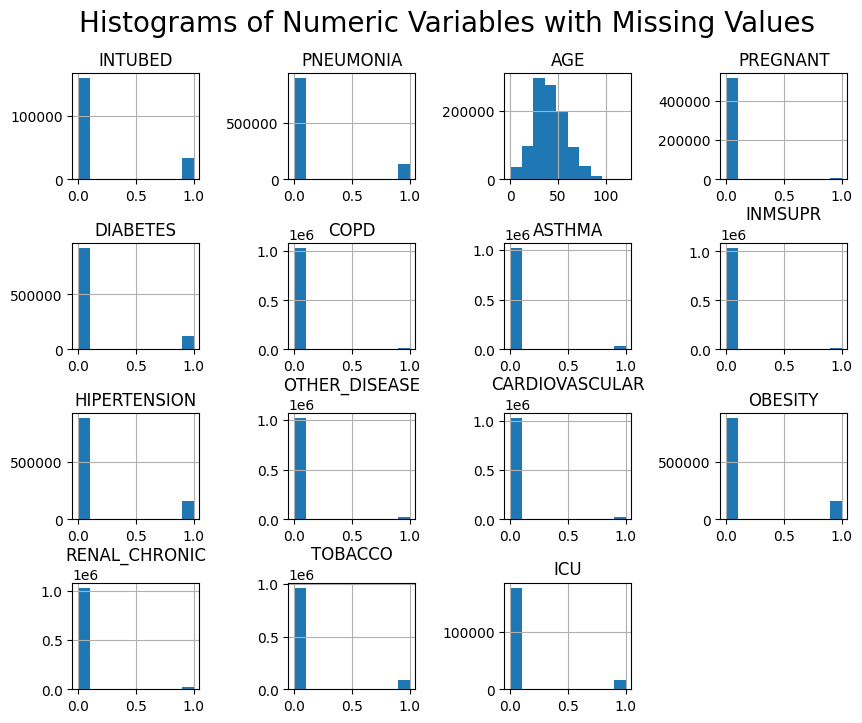

In [22]:
##histograms of the numerical features with missing data
num_features_missing.hist(figsize=(10,8))
plt.subplots_adjust(hspace=0.6, wspace=0.7)
plt.suptitle("Histograms of Numeric Variables with Missing Values", fontsize=20, y=0.96)  
plt.rcParams.update({'font.size': 10})
plt.show()

Observe:

- All distributions above are clearly categorical and one-hot encoded, with the exception of "AGE"
- The categorical distributions are highly skewed, so replacing the data based on most frequent would likely introduce bias

Let's now look at the columns with no missing values and understand how these distributions are shaped.

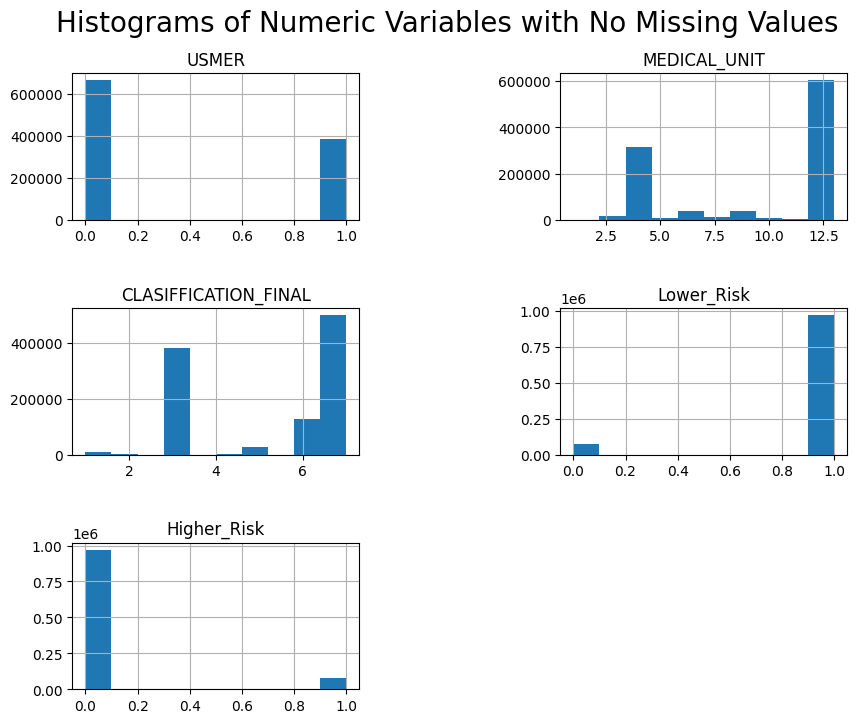

In [23]:
##histograms of the numerical features with no missing data
num_features_no_missing.hist(figsize=(10,8))
plt.subplots_adjust(hspace=0.6, wspace=0.7)
plt.suptitle("Histograms of Numeric Variables with No Missing Values", fontsize=20, y=0.96)
plt.rcParams.update({'font.size': 10})
plt.show()

Observation:

- As before, we are dealing mostly with categorical data

Let us check the "PREGNANT" data and it's relation to "SEX". This is easy to check and clean as only "FEMALE" can have positive "PREGNANT"

In [24]:
covid_pregnant_sex = covid[["PREGNANT", "SEX"]] 

In [25]:
covid_pregnant_sex[covid_pregnant_sex["SEX"] =='Male'].value_counts()

Series([], Name: count, dtype: int64)

In [26]:
covid_pregnant_sex[covid_pregnant_sex["SEX"] =='Female'].value_counts()

PREGNANT  SEX   
0.0       Female    513179
1.0       Female      8131
Name: count, dtype: int64

There are no "PREGNANT" values associated with "Male", but just in case we can try to clean this

In [27]:
covid.loc[:, 'PREGNANT'] = covid["PREGNANT"].apply(lambda x: 0 if x == 'Male' else x) 

In [28]:
covid['PREGNANT'].value_counts()

PREGNANT
0.0    513179
1.0      8131
Name: count, dtype: int64

## <a id='section1_4'></a>Missing Values Correlations

In [29]:
import missingno as msno


<Figure size 600x400 with 0 Axes>

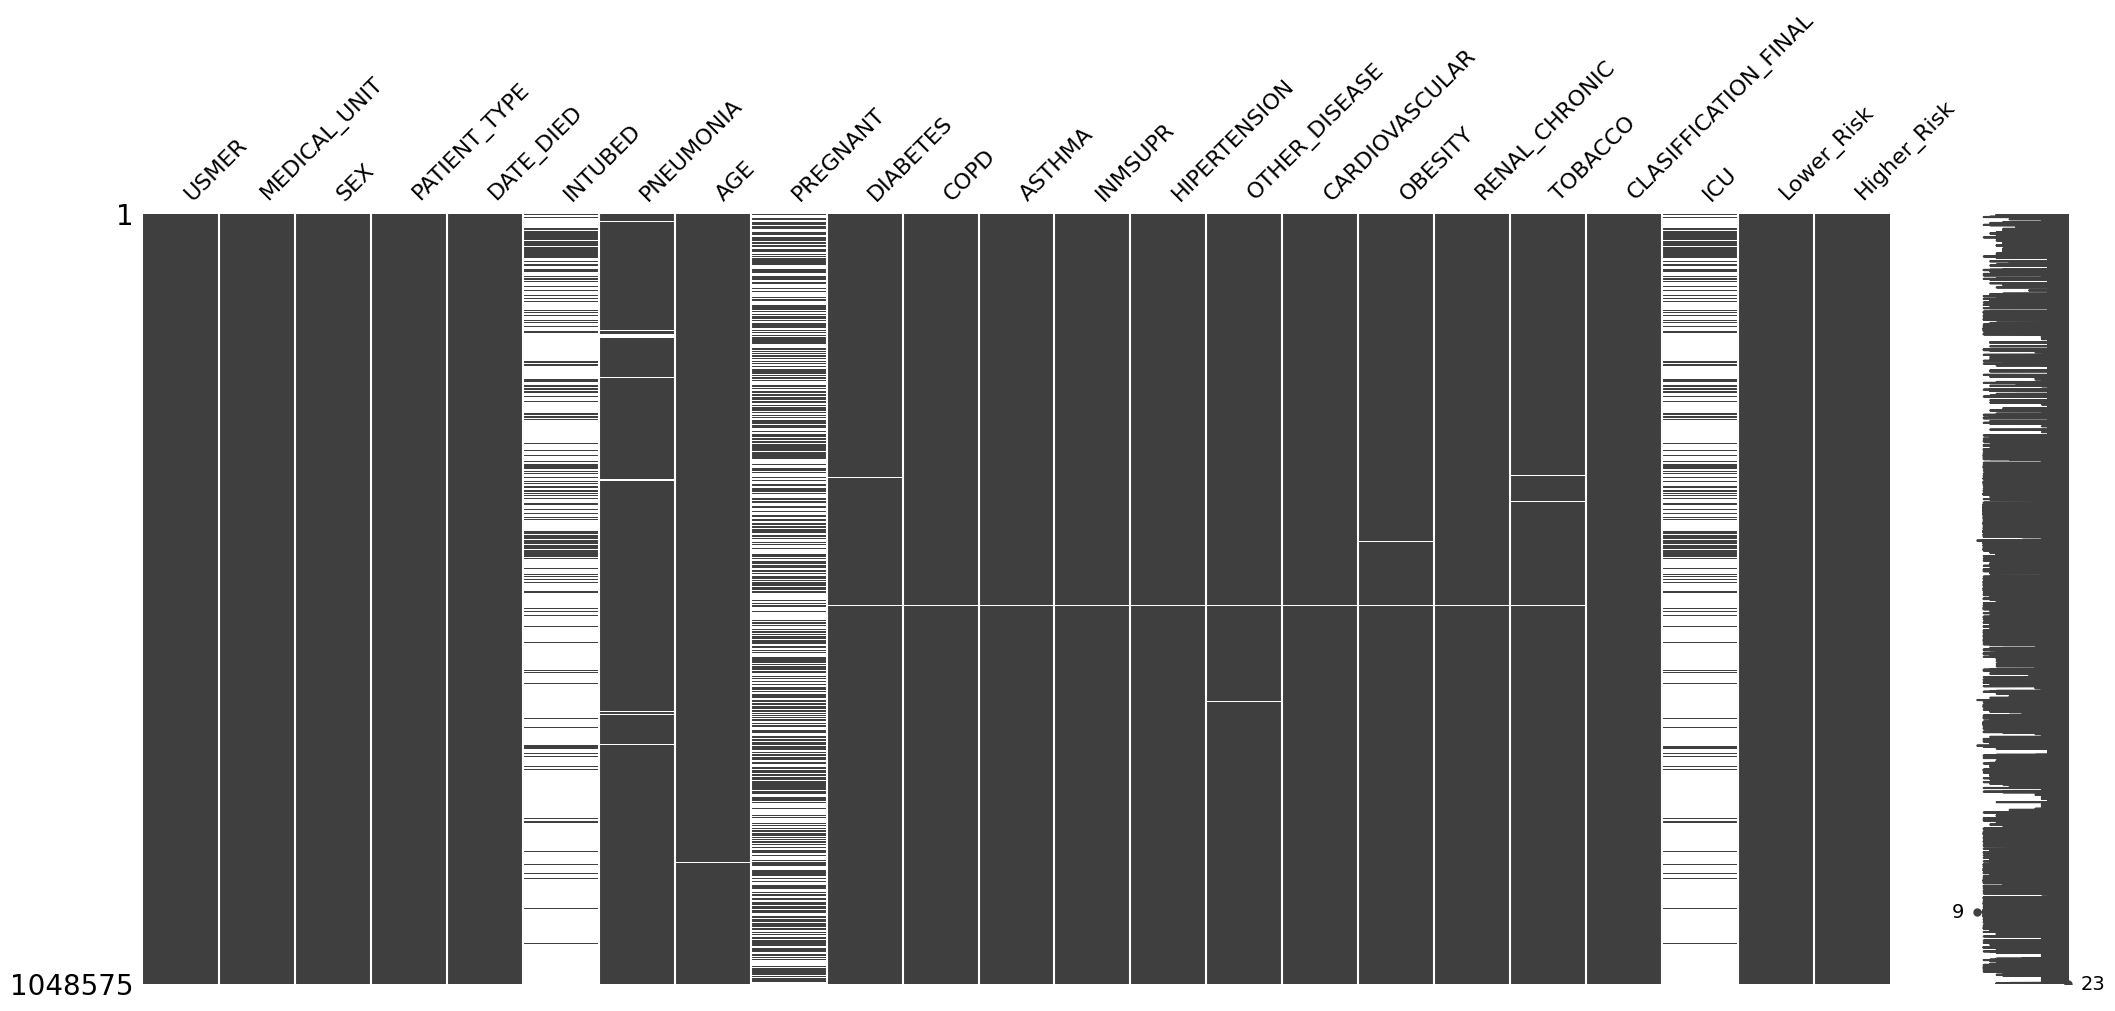

In [30]:
##plot the missing data points scaterred 
plt.figure(figsize=(6,4))
msno.matrix(covid) 
plt.show()

Observe:

- There is clearly a missing pattern in "INTUBED" and "ICU" : the missing values seem perfectly correlated
- The columns dealing with diseases seem to be correlated in terms of missing values

<Axes: >

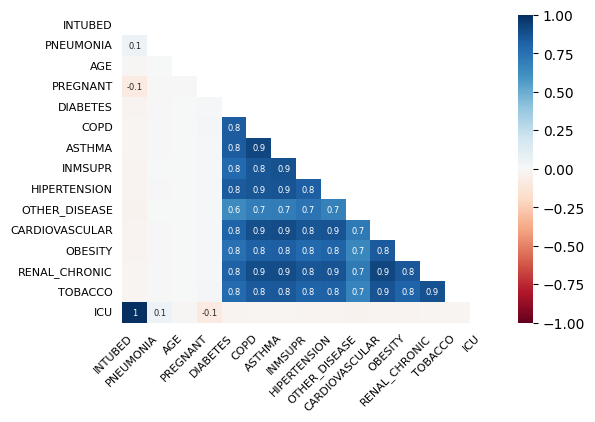

In [31]:
## plot the missingness correlation heatmap
msno.heatmap(covid, figsize=(6,4), fontsize=8)

Observation :

- Missing entries for "INTUBED" and "ICU| are perfectly correlated; this is because patients must be admitted to an Intensive Care Unit (ICU) in order to be "INTUBED". Hence, data for these two columns should be treated together
- There is a very high correlation of data missing for all diseases: if there is data missing for one disease, it is very likely missing for all other diseases.
- It seems that "PREGNANT" missing values are not correlated with anything else, this data is probably simply not available 

## <a id='section1_5'></a>Dealing with Missing Values

Dealing with missing values can be done in various ways:  by dropping rows with missing values, imputing the missing values or inserting some placeholder instead of the missing value. Dropping means that all associated rows will be lost, while imputing does introduce some bias depending on the model used. One smart way to deal with this is to look at the number of missing values and the corresponding distributions and then deal with them individually

The "AGE" column only has 345 missing values, these can be easily be replaced with the mean of the column without significantly affecting the distribution. Given the number of missing values in the "AGE" column, this must be a case of missing at random errors

In [32]:
##for age we can simply impute the median
covid['AGE'].fillna(covid['AGE'].mean(), inplace=True)

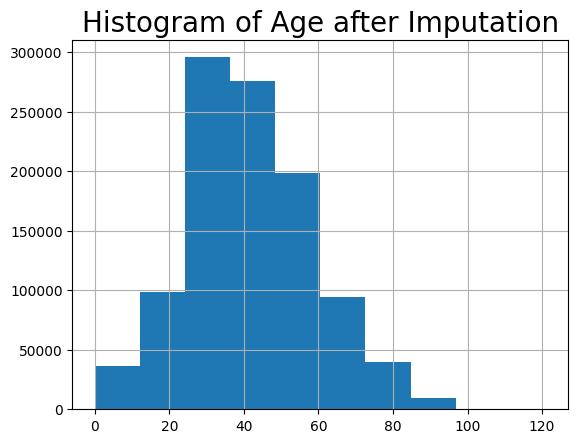

In [33]:
covid['AGE'].hist()
plt.title("Histogram of Age after Imputation", fontsize=20)
plt.show()

Now, the rest of the columns mostly have a number of missing data that is clearly not at random. This is particularly true of the columns associated to diseases : where one disease is missing, data regarding disease is missing too. This columns should be somehow "marked" as missing, so any algorithm learns differently from them. Let us fill them with some value that indicates _missingness_

In [34]:
disease_features = [ 'PNEUMONIA', 'DIABETES', 'COPD', 'ASTHMA',
       'INMSUPR', 'HIPERTENSION', 'OTHER_DISEASE', 'CARDIOVASCULAR', 'OBESITY',
       'RENAL_CHRONIC', 'TOBACCO']

In [35]:
for col in disease_features:
    covid[col].fillna(0.5, inplace=True)

Let's do the same with pregnancy, we introduce 0.5 (between 0 and 1) to indicate a new category of uncertainity. Hence, by 0.5 the value "unknown" is encoded

In [36]:
covid["PREGNANT"].fillna(0.5, inplace=True)

Let's now examine "ICU" and "INTUBED" more closey. If the existing values of these categories are also perfectly correlated there is no need to keep both of them into the final dataset.

In [37]:
corr_icu_intubed = covid[['ICU', 'INTUBED']].corr()

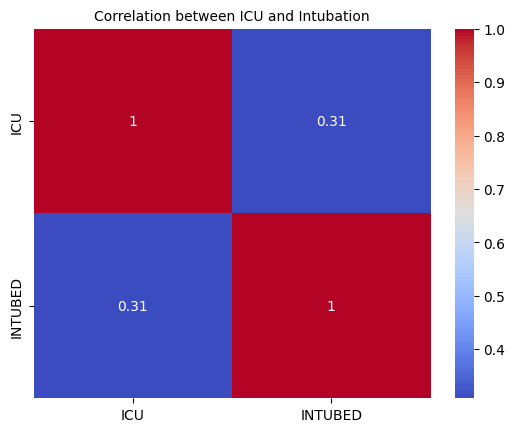

In [38]:
sns.heatmap(corr_icu_intubed, annot=True, cmap='coolwarm')
plt.title("Correlation between ICU and Intubation", fontsize=10)
plt.show()

It turns out the values are moderately correlated, hence it would make sense to deal with the "missingness" of each column while keeping the two values separated.

In [39]:
##this fills the missing values in the INTUBED column with 0.5
covid["INTUBED"].fillna(0.5, inplace=True)



In [40]:
##this fills the missing values in the ICU column with 0.5
covid["ICU"].fillna(0.5, inplace=True)


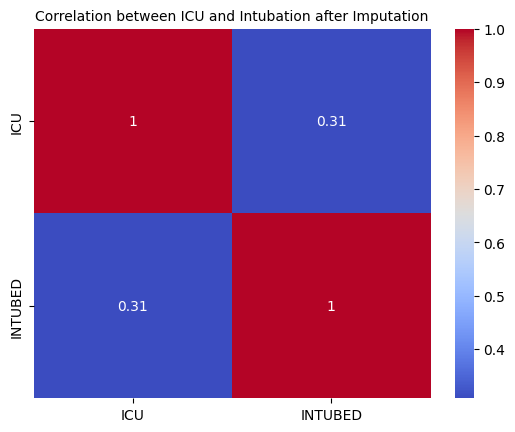

In [41]:
sns.heatmap(corr_icu_intubed, annot=True, cmap='coolwarm')
plt.title("Correlation between ICU and Intubation after Imputation", fontsize=10)
plt.show()

In sum, In all binary columns I introuduced 0.5 to indicate missing information. Although this strategy is simple, it can prove useful when one-hot encoding the categorical columns such that _missingness_ of various types of data also becomes a feature

It is important to create labels based on the "CLASSIFICATION_FINAL" : based on the dictionary <=3  indicates COVID diagnosis, while >=4 means that the patient may not be a carrier of covid

In [42]:
covid['COVID_POSITIVE'] = covid['CLASIFFICATION_FINAL'].apply(lambda x: 1 if x<=3 else 0)
covid['COVID_INCONCLUSIVE'] = covid['CLASIFFICATION_FINAL'].apply(lambda x: 1 if x>=4 else 0)

Since we are interested in distinguishing between high risk patients and low risk patients, I will select the data for which the patients are definitely infected with COVID-19.

<Axes: xlabel='COVID_POSITIVE'>

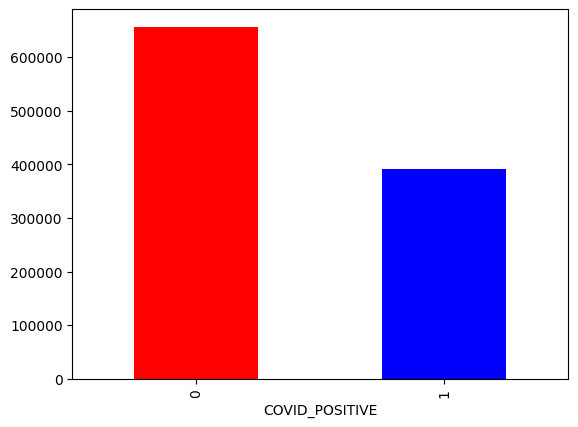

In [43]:
covid['COVID_POSITIVE'].value_counts().plot(kind='bar', color=['red', 'blue'])

In [44]:
##this is the dataframe of covid positive patients
covid_positive = covid[covid['COVID_POSITIVE'] == 1]

In [45]:
covid_positive.shape

(391979, 25)

The COVID_POSITIVE and COVID_INCONCLUSIVE columns are no longer necessary in the final dataframe, since it is clear that this contains all COVID-19 infected people. The same is true for the date the patient died, as we already classified everyone who died as High Risk. Also, since Higher Risk and Lower risk are complementary, we only need Higher Risk as our response.

In [46]:
covid_positive = covid_positive.drop(['COVID_POSITIVE', 'COVID_INCONCLUSIVE', 'DATE_DIED', 'Lower_Risk'], axis=1)
covid_positive.shape

(391979, 21)

In [47]:
covid_positive.columns

Index(['USMER', 'MEDICAL_UNIT', 'SEX', 'PATIENT_TYPE', 'INTUBED', 'PNEUMONIA',
       'AGE', 'PREGNANT', 'DIABETES', 'COPD', 'ASTHMA', 'INMSUPR',
       'HIPERTENSION', 'OTHER_DISEASE', 'CARDIOVASCULAR', 'OBESITY',
       'RENAL_CHRONIC', 'TOBACCO', 'CLASIFFICATION_FINAL', 'ICU',
       'Higher_Risk'],
      dtype='object')

## <a id='section1_6'></a>Clean Data Visualization

Let us visualize the clean data and see if any interesting patterns are immediately spotted.

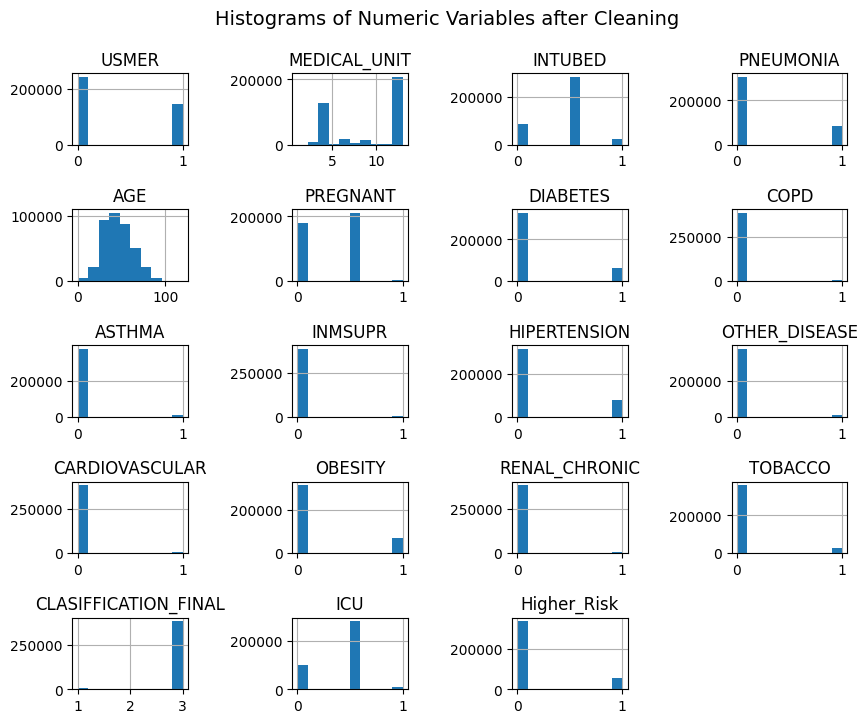

In [48]:
covid_positive.hist(figsize=(10,8))
plt.subplots_adjust(hspace=0.9, wspace=0.9)
plt.suptitle("Histograms of Numeric Variables after Cleaning", fontsize=14, y=0.96)
plt.rcParams.update({'font.size': 10})

Observe: 

- We have clean data, and the unknown data is simply encoded as 0.5
- Most distributions are certainly skewed: there are many patients without diseases than with any diseases
- The majority of the patients in this data set survived covid, so only a small proportion died (imbalanced classes)
- Less than half of the admited patients were diagnosed with Covid
- Most features are highly imbalanced
- ICU and INTUBED seem to contain the same information

Let's also look at some descriptive statistics

In [49]:
covid_positive.describe()

USMER   MEDICAL_UNIT        INTUBED      PNEUMONIA  \
count  391979.000000  391979.000000  391979.000000  391979.000000   
mean        0.375342       8.697948       0.420354       0.219509   
std         0.484212       3.764235       0.252334       0.413912   
min         0.000000       1.000000       0.000000       0.000000   
25%         0.000000       4.000000       0.500000       0.000000   
50%         0.000000      12.000000       0.500000       0.000000   
75%         1.000000      12.000000       0.500000       0.000000   
max         1.000000      13.000000       1.000000       1.000000   

                 AGE      PREGNANT       DIABETES           COPD  \
count  391979.000000  391979.00000  391979.000000  391979.000000   
mean       45.169177       0.27601       0.160299       0.017316   
std        16.434031       0.25561       0.365630       0.127196   
min         0.000000       0.00000       0.000000       0.000000   
25%        33.000000       0.00000       0.000000       0.000000   
50%        44.000000       0.50000       0.000000       0.000000   
75%        56.000000       0.50000       0.000000       0.000000   
max       120.000000       1.00000       1.000000       1.000000   

              ASTHMA        INMSUPR   HIPERTENSION  OTHER_DISEASE  \
count  391979.000000  391979.000000  391979.000000  391979.000000   
mean        0.028232       0.014025       0.197513       0.028282   
std         0.163097       0.113596       0.397010       0.161617   
min         0.000000       0.000000       0.000000       0.000000   
25%         0.000000       0.000000       0.000000       0.000000   
50%         0.000000       0.000000       0.000000       0.000000   
75%         0.000000       0.000000       0.000000       0.000000   
max         1.000000       1.000000       1.000000       1.000000   

       CARDIOVASCULAR        OBESITY  RENAL_CHRONIC        TOBACCO  \
count   391979.000000  391979.000000  391979.000000  391979.000000   
mean         0.023474       0.187384       0.022009       0.075167   
std          0.148446       0.389113       0.143748       0.261921   
min          0.000000       0.000000       0.000000       0.000000   
25%          0.000000       0.000000       0.000000       0.000000   
50%          0.000000       0.000000       0.000000       0.000000   
75%          0.000000       0.000000       0.000000       0.000000   
max          1.000000       1.000000       1.000000       1.000000   

       CLASIFFICATION_FINAL            ICU    Higher_Risk  
count         391979.000000  391979.000000  391979.000000  
mean               2.951393       0.386636       0.138365  
std                0.300216       0.239080       0.345283  
min                1.000000       0.000000       0.000000  
25%                3.000000       0.000000       0.000000  
50%                3.000000       0.500000       0.000000  
75%                3.000000       0.500000       0.000000  
max                3.000000       1.000000       1.000000

Observe:

- 75% of patients are under the age of 56

Let's also look at the categorical distributions

In [50]:
cat_covid = covid_positive.select_dtypes(include=['string']) 

In [51]:
cat_covid.columns

Index(['SEX', 'PATIENT_TYPE'], dtype='object')

Observe: There are only two "String" columns, "SEX" and "PATIENT_TYPE"

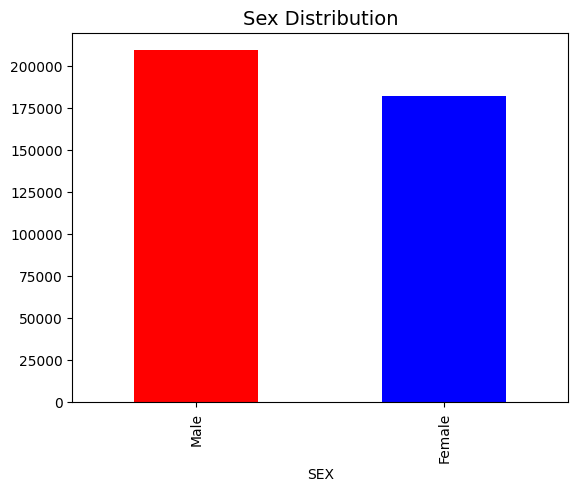

In [52]:
covid_positive["SEX"].value_counts().plot(kind='bar', color=['red', 'blue'])
plt.title("Sex Distribution", fontsize=14)
plt.show()

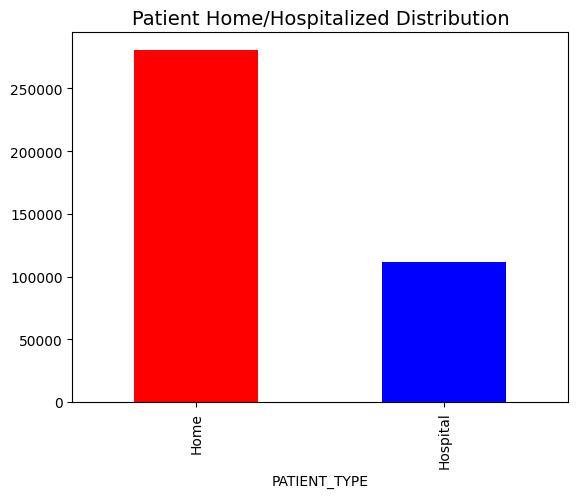

In [53]:
covid_positive["PATIENT_TYPE"].value_counts().plot(kind='bar', color=['red', 'blue'])
plt.title("Patient Home/Hospitalized Distribution", fontsize=14)
plt.show()

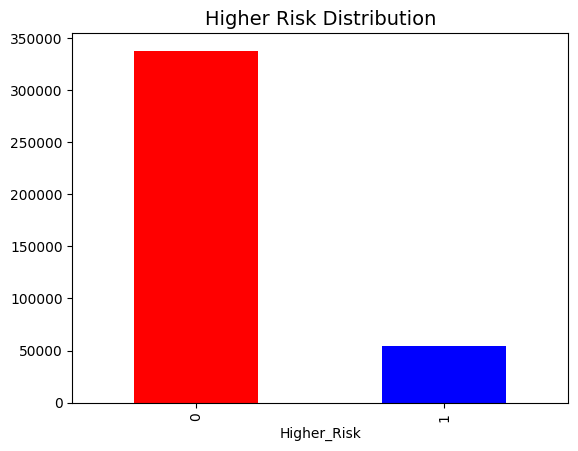

In [54]:
covid_positive["Higher_Risk"].value_counts().plot(kind='bar', color=['red', 'blue'])
plt.title("Higher Risk Distribution", fontsize=14)
plt.show()

In [55]:
covid_positive["Higher_Risk"].value_counts()[1]

54236

In [56]:
print("The percentage of patients at higher risk is", covid_positive["Higher_Risk"].value_counts()[1]/covid_positive["Higher_Risk"].value_counts()[0]*100) 

The percentage of patients at higher risk is 16.058363903915108


Note:

<ul>

1. The majority of the patients diagnosed with COVID-19 survived. Hence, when building a model that detects higher risk (the labels of higher risk are associated with patients that passed away) it is important to provide a high level of confidence in predictions of patients at high risk. What this means, is that the model should provide as few false negatives (FN) as possible. This is because a patient which is at high risk (positive) must receive urgent care to improve chances of survival. If this type of patient is classified as negative (not at high risk), then this could result in urgent care being delayed which could lead to loss of life, which is what this classification model tries to prevent. Hence, it is important that the model achieves high confidence in positive predictions, which is even more important that patients which are not at high risk being misclassified.

2. The classes "Higher_Risk", "Lower_Risk" are imbalanced, in the sense that there is a small percentage of the total patients at high risk (close to 16%). This means that model accuracy is crucial to be above a 84%%, anything less than that might as well classify patients at random.

3. In selecting the model, it is very important to be able to interpret the predictions. As such, I will aim to have a high as possible recall for the model (TPR). The true positive rate gives the ratio of correctly idetified positives $TPR = TP/(TP+FN)$ where TP stands for true positives (correctly classified cases) and FN stands for false negatives (positives that are incorrectly) classified. The recall (TPR) is even more important than accuracy for this problem, as recall can be clearly interpreted as the probability that a given prediction of a patient at high risk is correct.

</ul>

# <a id='section2'></a>2. Split the Data

Before I do anything else, I will create a training set, a test set and a validation set. This is to avoid contamining the data by further exploration on the training set. However, one consideration must be kept in mind, which is the very high imbalanced classes to be predicted - as the ratio of imbalanced classes is close to 8:100, we are dealing with highly imbalanced classes.

## <a id='section2_2'></a>Train/Test

Now we can create training and test sets from the new balanced samples. To do this, I will use Scikit-Learn as in the following.

In [57]:
from sklearn.model_selection import train_test_split

In [58]:
##split the original data (no undersampling) into train and test sets
train, test = train_test_split(covid_positive, test_size=0.2, stratify =covid_positive['Higher_Risk'], random_state=1923)

In [59]:
##check the proportions of the higher risk group in both the training and test sets
print(train["Higher_Risk"].value_counts()/len(train))
print(test["Higher_Risk"].value_counts()/len(test))

Higher_Risk
0    0.861635
1    0.138365
Name: count, dtype: float64
Higher_Risk
0    0.861638
1    0.138362
Name: count, dtype: float64


As seen above, the test set and the training set have similar proportions of the minority class (Higher Risk patients)

Let us do all exploration on a copy of the covid data. The models will be tested on the training sets that are randomly sampled, and the ones that are consistently performant will be selected.

In [60]:
covid_eda = train.copy()

#  <a id='section3'></a>3. Explore the Data

## <a id='section3_1'></a>Looking for Correlations

In [61]:
covid_eda.head()

USMER  MEDICAL_UNIT     SEX PATIENT_TYPE  INTUBED  PNEUMONIA   AGE  \
446648      0            12  Female     Hospital      0.0        1.0  68.0   
582398      0            12  Female         Home      0.5        0.0  23.0   
629289      0            12    Male         Home      0.5        0.0  22.0   
585391      1            12    Male     Hospital      0.0        1.0  69.0   
573687      0            12    Male     Hospital      0.0        0.0  52.0   

        PREGNANT  DIABETES  COPD  ...  INMSUPR  HIPERTENSION  OTHER_DISEASE  \
446648       0.0       1.0   0.0  ...      0.0           1.0            0.0   
582398       0.0       0.0   0.0  ...      0.0           0.0            0.0   
629289       0.5       0.0   0.0  ...      0.0           0.0            0.0   
585391       0.5       1.0   0.0  ...      0.0           1.0            0.0   
573687       0.5       0.0   0.0  ...      0.0           0.0            0.0   

        CARDIOVASCULAR  OBESITY  RENAL_CHRONIC  TOBACCO  CLASIFFICATION_FINAL  \
446648             0.0      0.0            1.0      0.0                     3   
582398             0.0      0.0            0.0      0.0                     3   
629289             0.0      0.0            0.0      0.0                     3   
585391             0.0      0.0            0.0      0.0                     3   
573687             0.0      0.0            0.0      0.0                     3   

        ICU  Higher_Risk  
446648  0.0            1  
582398  0.5            0  
629289  0.5            0  
585391  0.0            0  
573687  0.0            0  

[5 rows x 21 columns]

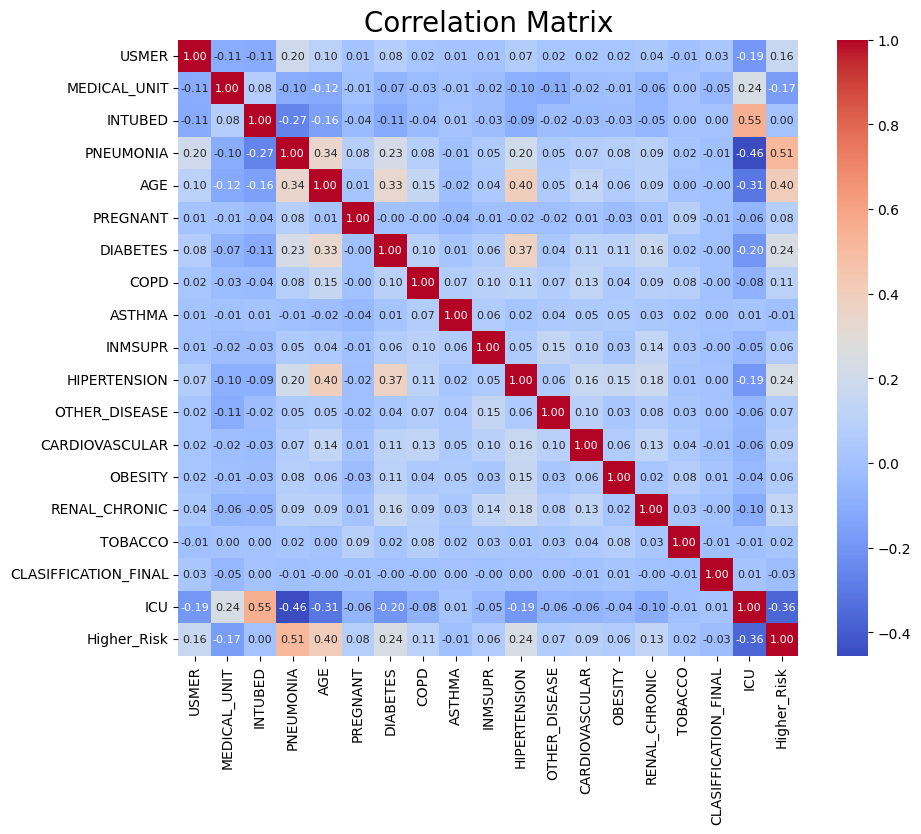

In [62]:
covid_num = covid_eda.select_dtypes(include=[np.number])
corr_cov = covid_num.corr()
plt.figure(figsize=(10,8))
sns.heatmap(corr_cov, annot=True, cmap='coolwarm',  fmt=".2f", annot_kws={"size": 8})
plt.title("Correlation Matrix", fontsize=20)
plt.show()

Observe:

- High correlation between ICU and INTUBED: This is expected also due to imputed values for uncertainity (missing data in one column perfectly predicts missing data in another columns)
- There is a high correlation between Higher_Risk and PNEUMONIA (46%) and Higher_risk and AGE (32) : this suggests older patients with pneumonia are at risk of death
- AGE and HIPERTENSION are also correlated
- The correlation between COVID_POSITIVE and Higher_risk is only 19%, which suggest that other factors might be at play
- PNEUMONIA is also a risk factor for being admitted into intensive care (46%) correlation
- AGE increases the probability of "DIABETES" and "HIPERTENSION"
- There is a 36% correlation of being admitted at ICU (Intensive Care Unit) and surviving covid : this suggests that receiving emergency care can definitely increase the chances of survival for patients with COVID-19

In [63]:
##let's look at factors that are highly correlated with death
corr_cov["Higher_Risk"].sort_values(ascending=False)

Higher_Risk             1.000000
PNEUMONIA               0.515000
AGE                     0.398559
DIABETES                0.238632
HIPERTENSION            0.235139
USMER                   0.160149
RENAL_CHRONIC           0.131561
COPD                    0.106502
CARDIOVASCULAR          0.090065
PREGNANT                0.079766
OTHER_DISEASE           0.066278
OBESITY                 0.060654
INMSUPR                 0.056669
TOBACCO                 0.015292
INTUBED                 0.003431
ASTHMA                 -0.010641
CLASIFFICATION_FINAL   -0.027962
MEDICAL_UNIT           -0.169646
ICU                    -0.364731
Name: Higher_Risk, dtype: float64

Observe:

 - Pneumonia, Age and Diabetes are the most correlated features with death.

## <a id='section3_2'></a>Experimenting with Transformations

It is clear that most columns are categorical, contains positives, negatives and missing values. To deal with this data, we can use KBinsDiscretizer that uses a Kmeans algorithm to bucketize the columns and visualize how close it is to our predictions.

In [64]:
##Let's deal with the categories that are already encoded
cat_num = covid_eda.select_dtypes(include=[np.number])
cat_num.drop(['MEDICAL_UNIT', 'AGE', 'CLASIFFICATION_FINAL'], axis=1, inplace=True)

In [65]:
[cat_num.columns]

[Index(['USMER', 'INTUBED', 'PNEUMONIA', 'PREGNANT', 'DIABETES', 'COPD',
        'ASTHMA', 'INMSUPR', 'HIPERTENSION', 'OTHER_DISEASE', 'CARDIOVASCULAR',
        'OBESITY', 'RENAL_CHRONIC', 'TOBACCO', 'ICU', 'Higher_Risk'],
       dtype='object')]

array([[<Axes: title={'center': 'ICU'}>,
        <Axes: title={'center': 'INTUBED'}>]], dtype=object)

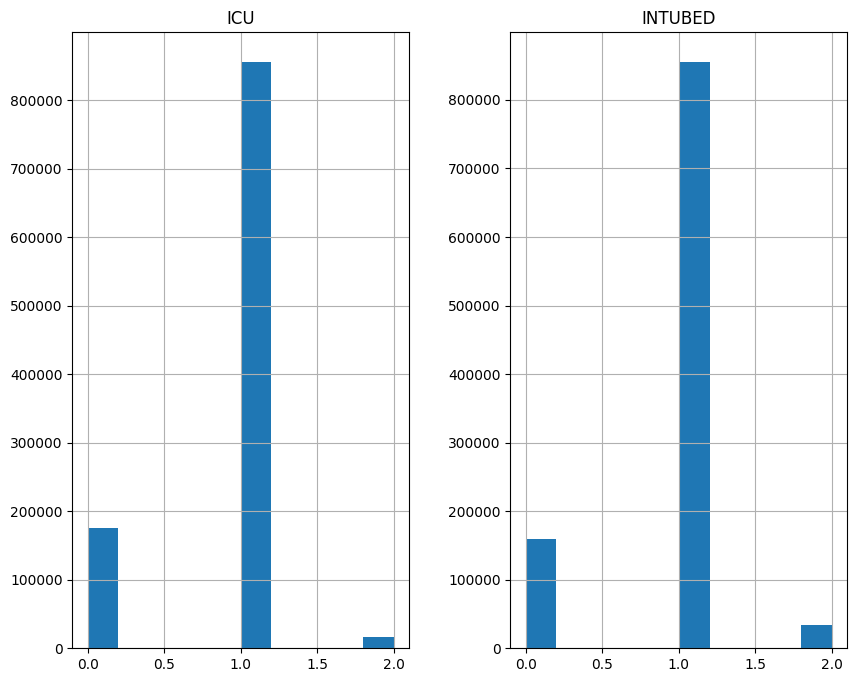

In [66]:
from sklearn.preprocessing import KBinsDiscretizer
dataframe_urgent = covid[['ICU', 'INTUBED']].copy() ##create a new dataframe with only with numerical columns
##create an instance of the KBinsDiscretizer class with 3 bins and the kmeans strategy; 
##the encode argument is set to ordinal to label each bin with an integer
##the k-means strategies ensures that values in each bin have the same nearest center of a 1D k-means cluster
discretizer_3bins = KBinsDiscretizer(n_bins=3, encode='ordinal', strategy='kmeans')
##let's now transform the data and plot it to examine if the results is very different from the manual approach
dataframe_buketized = discretizer_3bins.fit_transform(dataframe_urgent)
dataframe_buketized = pd.DataFrame(dataframe_buketized, columns=['ICU', 'INTUBED'])
##let us plot the histograms of the bucketized data
dataframe_buketized.hist(figsize=(10,8))

The Discretizer has simply replaced the values of the original distributions with ordinal numbers. Hence, using K-means with 3 clusters, it found very similar categories (the edges of the discretizer are given in the cell below)

In [67]:
##this shows the edges of the bins
for i, edges in enumerate(discretizer_3bins.bin_edges_):
    print(f"{edges}")

[0.   0.25 0.75 1.  ]
[0.   0.25 0.75 1.  ]


An alternative treatment, is to transform these column types to "object" and then one-hot encode based on the original values while keeping in mind that "0.5" indicates missing values ( remember that I used "0.5" to encode missing values for categorical one-hot encoded columns)

In [68]:
for col in cat_num.columns: 
    covid_eda[col] = covid_eda[col].astype('string')

In [69]:
covid_eda.info()

<class 'pandas.core.frame.DataFrame'>
Index: 313583 entries, 446648 to 492124
Data columns (total 21 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   USMER                 313583 non-null  string 
 1   MEDICAL_UNIT          313583 non-null  int64  
 2   SEX                   313583 non-null  string 
 3   PATIENT_TYPE          313583 non-null  string 
 4   INTUBED               313583 non-null  string 
 5   PNEUMONIA             313583 non-null  string 
 6   AGE                   313583 non-null  float64
 7   PREGNANT              313583 non-null  string 
 8   DIABETES              313583 non-null  string 
 9   COPD                  313583 non-null  string 
 10  ASTHMA                313583 non-null  string 
 11  INMSUPR               313583 non-null  string 
 12  HIPERTENSION          313583 non-null  string 
 13  OTHER_DISEASE         313583 non-null  string 
 14  CARDIOVASCULAR        313583 non-null  string 
 15  

In [70]:
##let's create a dataframe containing all categories (string columns)
covid_eda_all_cat = covid_eda.select_dtypes(include=['string'])

In [71]:
covid_eda_all_cat

USMER     SEX PATIENT_TYPE INTUBED PNEUMONIA PREGNANT DIABETES COPD  \
446648     0  Female     Hospital     0.0       1.0      0.0      1.0  0.0   
582398     0  Female         Home     0.5       0.0      0.0      0.0  0.0   
629289     0    Male         Home     0.5       0.0      0.5      0.0  0.0   
585391     1    Male     Hospital     0.0       1.0      0.5      1.0  0.0   
573687     0    Male     Hospital     0.0       0.0      0.5      0.0  0.0   
...      ...     ...          ...     ...       ...      ...      ...  ...   
527538     0    Male         Home     0.5       0.0      0.5      0.0  0.0   
567736     0    Male         Home     0.5       0.0      0.5      0.0  0.0   
121787     0    Male     Hospital     0.0       0.0      0.5      1.0  0.0   
544777     1    Male         Home     0.5       0.0      0.5      0.0  0.0   
492124     0    Male         Home     0.5       0.0      0.5      0.0  0.0   

       ASTHMA INMSUPR HIPERTENSION OTHER_DISEASE CARDIOVASCULAR OBESITY  \
446648    0.0     0.0          1.0           0.0            0.0     0.0   
582398    0.0     0.0          0.0           0.0            0.0     0.0   
629289    0.0     0.0          0.0           0.0            0.0     0.0   
585391    0.0     0.0          1.0           0.0            0.0     0.0   
573687    0.0     0.0          0.0           0.0            0.0     0.0   
...       ...     ...          ...           ...            ...     ...   
527538    0.0     0.0          0.0           0.0            0.0     0.0   
567736    0.0     0.0          0.0           0.0            0.0     0.0   
121787    0.0     0.0          1.0           0.0            0.0     1.0   
544777    0.0     0.0          0.0           0.0            0.0     0.0   
492124    0.0     0.0          0.0           0.0            0.0     0.0   

       RENAL_CHRONIC TOBACCO  ICU Higher_Risk  
446648           1.0     0.0  0.0           1  
582398           0.0     0.0  0.5           0  
629289           0.0     0.0  0.5           0  
585391           0.0     0.0  0.0           0  
573687           0.0     0.0  0.0           0  
...              ...     ...  ...         ...  
527538           0.0     0.0  0.5           0  
567736           0.0     0.0  0.5           0  
121787           1.0     1.0  0.0           0  
544777           0.0     0.0  0.5           0  
492124           0.0     0.0  0.5           0  

[313583 rows x 18 columns]

Now, let us one-hot encode these features. To do this, I will built a pipeline via the tools provided with Scikit-Learn.

In [72]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import make_pipeline  

In [73]:
##pipeline that one-hot encodes the categorical features
one_hot = make_pipeline(OneHotEncoder(sparse=False, handle_unknown='ignore'))

In [74]:
##let us apply the pipeline to the categorical features
cat_num_onehot = one_hot.fit_transform(covid_eda_all_cat)


/opt/homebrew/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [75]:
##this returns a numpy array with one-hot encoded features
cat_num_onehot

array([[1., 0., 1., ..., 0., 0., 1.],
       [1., 0., 1., ..., 0., 1., 0.],
       [1., 0., 0., ..., 0., 1., 0.],
       ...,
       [1., 0., 0., ..., 0., 1., 0.],
       [0., 1., 0., ..., 0., 1., 0.],
       [1., 0., 0., ..., 0., 1., 0.]])

In [76]:
##we can put the one-hot encoded features in a dataframe
cat_num_onehot = pd.DataFrame(cat_num_onehot, columns = one_hot.get_feature_names_out(), index=covid_eda_all_cat.index)

In [77]:
##we have easilty one-hot encoded the categorical features and put them in a dataframe while preserving the index
cat_num_onehot

USMER_0  USMER_1  SEX_Female  SEX_Male  PATIENT_TYPE_Home  \
446648      1.0      0.0         1.0       0.0                0.0   
582398      1.0      0.0         1.0       0.0                1.0   
629289      1.0      0.0         0.0       1.0                1.0   
585391      0.0      1.0         0.0       1.0                0.0   
573687      1.0      0.0         0.0       1.0                0.0   
...         ...      ...         ...       ...                ...   
527538      1.0      0.0         0.0       1.0                1.0   
567736      1.0      0.0         0.0       1.0                1.0   
121787      1.0      0.0         0.0       1.0                0.0   
544777      0.0      1.0         0.0       1.0                1.0   
492124      1.0      0.0         0.0       1.0                1.0   

        PATIENT_TYPE_Hospital  INTUBED_0.0  INTUBED_0.5  INTUBED_1.0  \
446648                    1.0          1.0          0.0          0.0   
582398                    0.0          0.0          1.0          0.0   
629289                    0.0          0.0          1.0          0.0   
585391                    1.0          1.0          0.0          0.0   
573687                    1.0          1.0          0.0          0.0   
...                       ...          ...          ...          ...   
527538                    0.0          0.0          1.0          0.0   
567736                    0.0          0.0          1.0          0.0   
121787                    1.0          1.0          0.0          0.0   
544777                    0.0          0.0          1.0          0.0   
492124                    0.0          0.0          1.0          0.0   

        PNEUMONIA_0.0  ...  RENAL_CHRONIC_0.5  RENAL_CHRONIC_1.0  TOBACCO_0.0  \
446648            0.0  ...                0.0                1.0          1.0   
582398            1.0  ...                0.0                0.0          1.0   
629289            1.0  ...                0.0                0.0          1.0   
585391            0.0  ...                0.0                0.0          1.0   
573687            1.0  ...                0.0                0.0          1.0   
...               ...  ...                ...                ...          ...   
527538            1.0  ...                0.0                0.0          1.0   
567736            1.0  ...                0.0                0.0          1.0   
121787            1.0  ...                0.0                1.0          0.0   
544777            1.0  ...                0.0                0.0          1.0   
492124            1.0  ...                0.0                0.0          1.0   

        TOBACCO_0.5  TOBACCO_1.0  ICU_0.0  ICU_0.5  ICU_1.0  Higher_Risk_0  \
446648          0.0          0.0      1.0      0.0      0.0            0.0   
582398          0.0          0.0      0.0      1.0      0.0            1.0   
629289          0.0          0.0      0.0      1.0      0.0            1.0   
585391          0.0          0.0      1.0      0.0      0.0            1.0   
573687          0.0          0.0      1.0      0.0      0.0            1.0   
...             ...          ...      ...      ...      ...            ...   
527538          0.0          0.0      0.0      1.0      0.0            1.0   
567736          0.0          0.0      0.0      1.0      0.0            1.0   
121787          0.0          1.0      1.0      0.0      0.0            1.0   
544777          0.0          0.0      0.0      1.0      0.0            1.0   
492124          0.0          0.0      0.0      1.0      0.0            1.0   

        Higher_Risk_1  
446648            1.0  
582398            0.0  
629289            0.0  
585391            0.0  
573687            0.0  
...               ...  
527538            0.0  
567736            0.0  
121787            0.0  
544777            0.0  
492124            0.0  

[313583 rows x 50 columns]

In [78]:
cat_num_onehot.shape

(313583, 50)

Observe:

-The number of categories greatly increased due to having one-hot encoded features

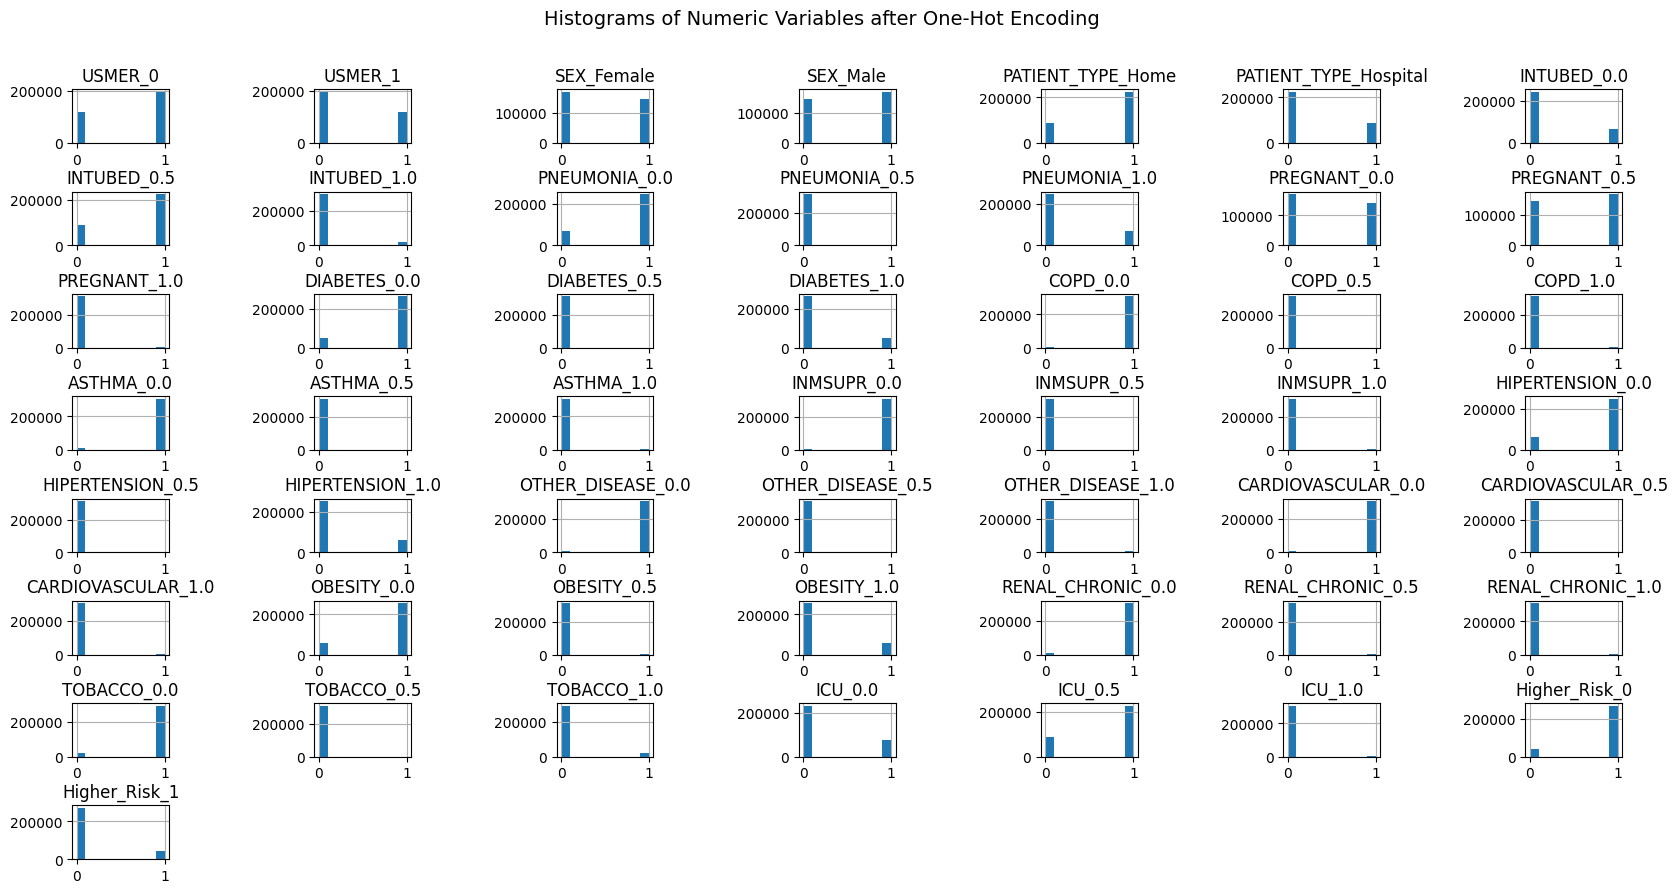

In [79]:
##let us visualize the new features
cat_num_onehot.hist(figsize=(20,10))
plt.subplots_adjust(hspace=0.9, wspace=1.5)
plt.suptitle("Histograms of Numeric Variables after One-Hot Encoding", fontsize=14, y=0.96)
plt.rcParams.update({'font.size': 8})


Observe: 

- all the new columns have the feature and the characteristic they one-hot encode: 0.0 is a negative, 1.0 is a positive and 0.5 is a missing value
- for the "SEX" and "PATIENT_TYPE" as well as for the COVID results we have one-hot encoded categories
- all these can be fed to the machine learning model

One category that we did not treat is the medical unit. We can try to find clusters with KMEans and Bucketize

array([[<Axes: title={'center': 'MEDICAL_UNIT'}>]], dtype=object)

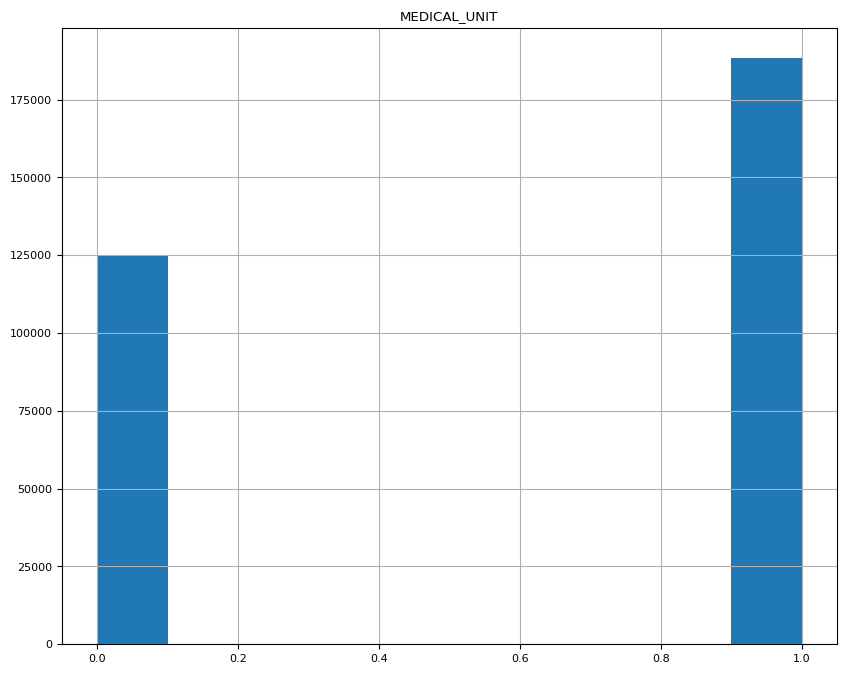

In [80]:

dataframe_medunit = covid_eda[['MEDICAL_UNIT']].copy() 
##let's create a discretizer with 2 bins and the kmeans strategy;
discretizer_2bins = KBinsDiscretizer(n_bins=2, encode='ordinal', strategy='kmeans')
##let's now transform the data and plot it to examine if the results is very different from the manual approach
dataframe_buketized_med = discretizer_2bins.fit_transform(dataframe_medunit)
dataframe_buketized_med = pd.DataFrame(dataframe_buketized_med, columns=['MEDICAL_UNIT'])
##let us plot the histograms of the bucketized data
dataframe_buketized_med.hist(figsize=(10,8))

In [81]:
##let's look at the edges of the bins
for i, edges in enumerate(discretizer_2bins.bin_edges_):
    print(f"{edges}")

[ 1.          7.93952348 13.        ]


It seems that the Discretizer has grouped the instances between 1 and 8, and 8 and 13. This seems consistent with the previous distribution. As there is not information on what the numbers associated with the medical units mean, everything is grouped under two clusters, showing "Type I" Medical Unit and "Type II" Medical Unit

# 4. <a id='section4'></a>Pre-process data for Machine Learning Algorithms

- The previous transformations can all be put into pipelines
- I will build a pipeline that contains the one-hot encoding transformations, as well as scalling 
- I will then apply this pipeline to data : training, test and validation
- With the help of an evaluation metric, I will then test various ML models from Scikit-Learn

## <a id='section4_1'></a>Built a Pre-Processing Pipeline

In [82]:
##column transformers to organize the pipelines
from sklearn.compose import ColumnTransformer
##make_pipeline to create a pipeline based on Function transformers
from sklearn.pipeline import make_pipeline
##StandardScaler to scale the numerical features
from sklearn.preprocessing import StandardScaler
##and function transformer to apply the discretizer
from sklearn.preprocessing import FunctionTransformer


In [83]:
##displays transformations
from sklearn import set_config

set_config(display='diagram')

In [84]:
from sklearn.base import BaseEstimator, TransformerMixin

class CustomTransformer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        ## Apply your transformation
        return X.astype(str)

    def get_feature_names_out(self, input_features=None):
        ## Implement this method to return the feature names
        return input_features

In [85]:
##this creates a pipeline that only does one-hot encoding
cat_pipeline_default = make_pipeline(
                CustomTransformer(),
                OneHotEncoder(handle_unknown='ignore')
                ) 

##this creates a pipeline that only does one-hot encoding
cat_pipeline = make_pipeline(
                OneHotEncoder(handle_unknown='ignore')
                )

In [86]:
##Now I am creating two pipelines for discretizing, and one-hot-encoding.

bucket_pipeline_1 = make_pipeline(
    KBinsDiscretizer(n_bins=2, encode='ordinal', strategy='kmeans', random_state=1923),
     OneHotEncoder(handle_unknown='ignore')) 



In [87]:
## now for standard scaling
num_pipeline = make_pipeline(
    StandardScaler()
)

Now let us define the pre-processing pipeline, that allows the transformations to be imputed

In [88]:

preprocessing = ColumnTransformer([
        
        ('bucket_pipeline_1', bucket_pipeline_1, ['MEDICAL_UNIT']),
        ('categorical', cat_pipeline_default, ['USMER', 'INTUBED', 'PNEUMONIA', 'PREGNANT', 'DIABETES', 'COPD',
        'ASTHMA', 'INMSUPR', 'HIPERTENSION', 'OTHER_DISEASE', 'CARDIOVASCULAR',
        'OBESITY', 'RENAL_CHRONIC', 'TOBACCO', 'ICU']),
        ('numerical', num_pipeline, ['AGE']),
        ('categorical simple', cat_pipeline, ['SEX', 'PATIENT_TYPE']),
         ('drop_age', 'drop', ['CLASIFFICATION_FINAL', 'Higher_Risk']),
    ], remainder='passthrough')

Let us test it on a copy of the data

In [89]:
covid_prep = covid_positive.copy()

In [90]:
covid_pip_prep = preprocessing.fit_transform(covid_prep)

In [91]:
##after pre-processing, we have a numpy array. Let us put it in a dataframe
covid_pip_prep =pd.DataFrame(covid_pip_prep, columns=preprocessing.get_feature_names_out(), index=covid_prep.index)

In [92]:
covid_pip_prep

bucket_pipeline_1__MEDICAL_UNIT_0.0  \
0                                        1.0   
2                                        1.0   
4                                        1.0   
5                                        1.0   
6                                        1.0   
...                                      ...   
1047933                                  0.0   
1047934                                  0.0   
1047935                                  0.0   
1047936                                  0.0   
1047937                                  0.0   

         bucket_pipeline_1__MEDICAL_UNIT_1.0  categorical__USMER_0  \
0                                        0.0                   1.0   
2                                        0.0                   1.0   
4                                        0.0                   1.0   
5                                        0.0                   1.0   
6                                        0.0                   1.0   
...                                      ...                   ...   
1047933                                  1.0                   0.0   
1047934                                  1.0                   0.0   
1047935                                  1.0                   0.0   
1047936                                  1.0                   1.0   
1047937                                  1.0                   1.0   

         categorical__USMER_1  categorical__INTUBED_0.0  \
0                         0.0                       0.0   
2                         0.0                       0.0   
4                         0.0                       0.0   
5                         0.0                       1.0   
6                         0.0                       0.0   
...                       ...                       ...   
1047933                   1.0                       1.0   
1047934                   1.0                       0.0   
1047935                   1.0                       0.0   
1047936                   0.0                       0.0   
1047937                   0.0                       0.0   

         categorical__INTUBED_0.5  categorical__INTUBED_1.0  \
0                             1.0                       0.0   
2                             0.0                       1.0   
4                             1.0                       0.0   
5                             0.0                       0.0   
6                             1.0                       0.0   
...                           ...                       ...   
1047933                       0.0                       0.0   
1047934                       1.0                       0.0   
1047935                       1.0                       0.0   
1047936                       1.0                       0.0   
1047937                       1.0                       0.0   

         categorical__PNEUMONIA_0.0  categorical__PNEUMONIA_0.5  \
0                               0.0                         0.0   
2                               1.0                         0.0   
4                               1.0                         0.0   
5                               0.0                         0.0   
6                               1.0                         0.0   
...                             ...                         ...   
1047933                         1.0                         0.0   
1047934                         1.0                         0.0   
1047935                         1.0                         0.0   
1047936                         1.0                         0.0   
1047937                         1.0                         0.0   

         categorical__PNEUMONIA_1.0  ...  categorical__TOBACCO_0.5  \
0                               1.0  ...                       0.0   
2                               0.0  ...                       0.0   
4                               0.0  ...                       0.0   
5                               1.0  ...

<Figure size 2000x1000 with 0 Axes>

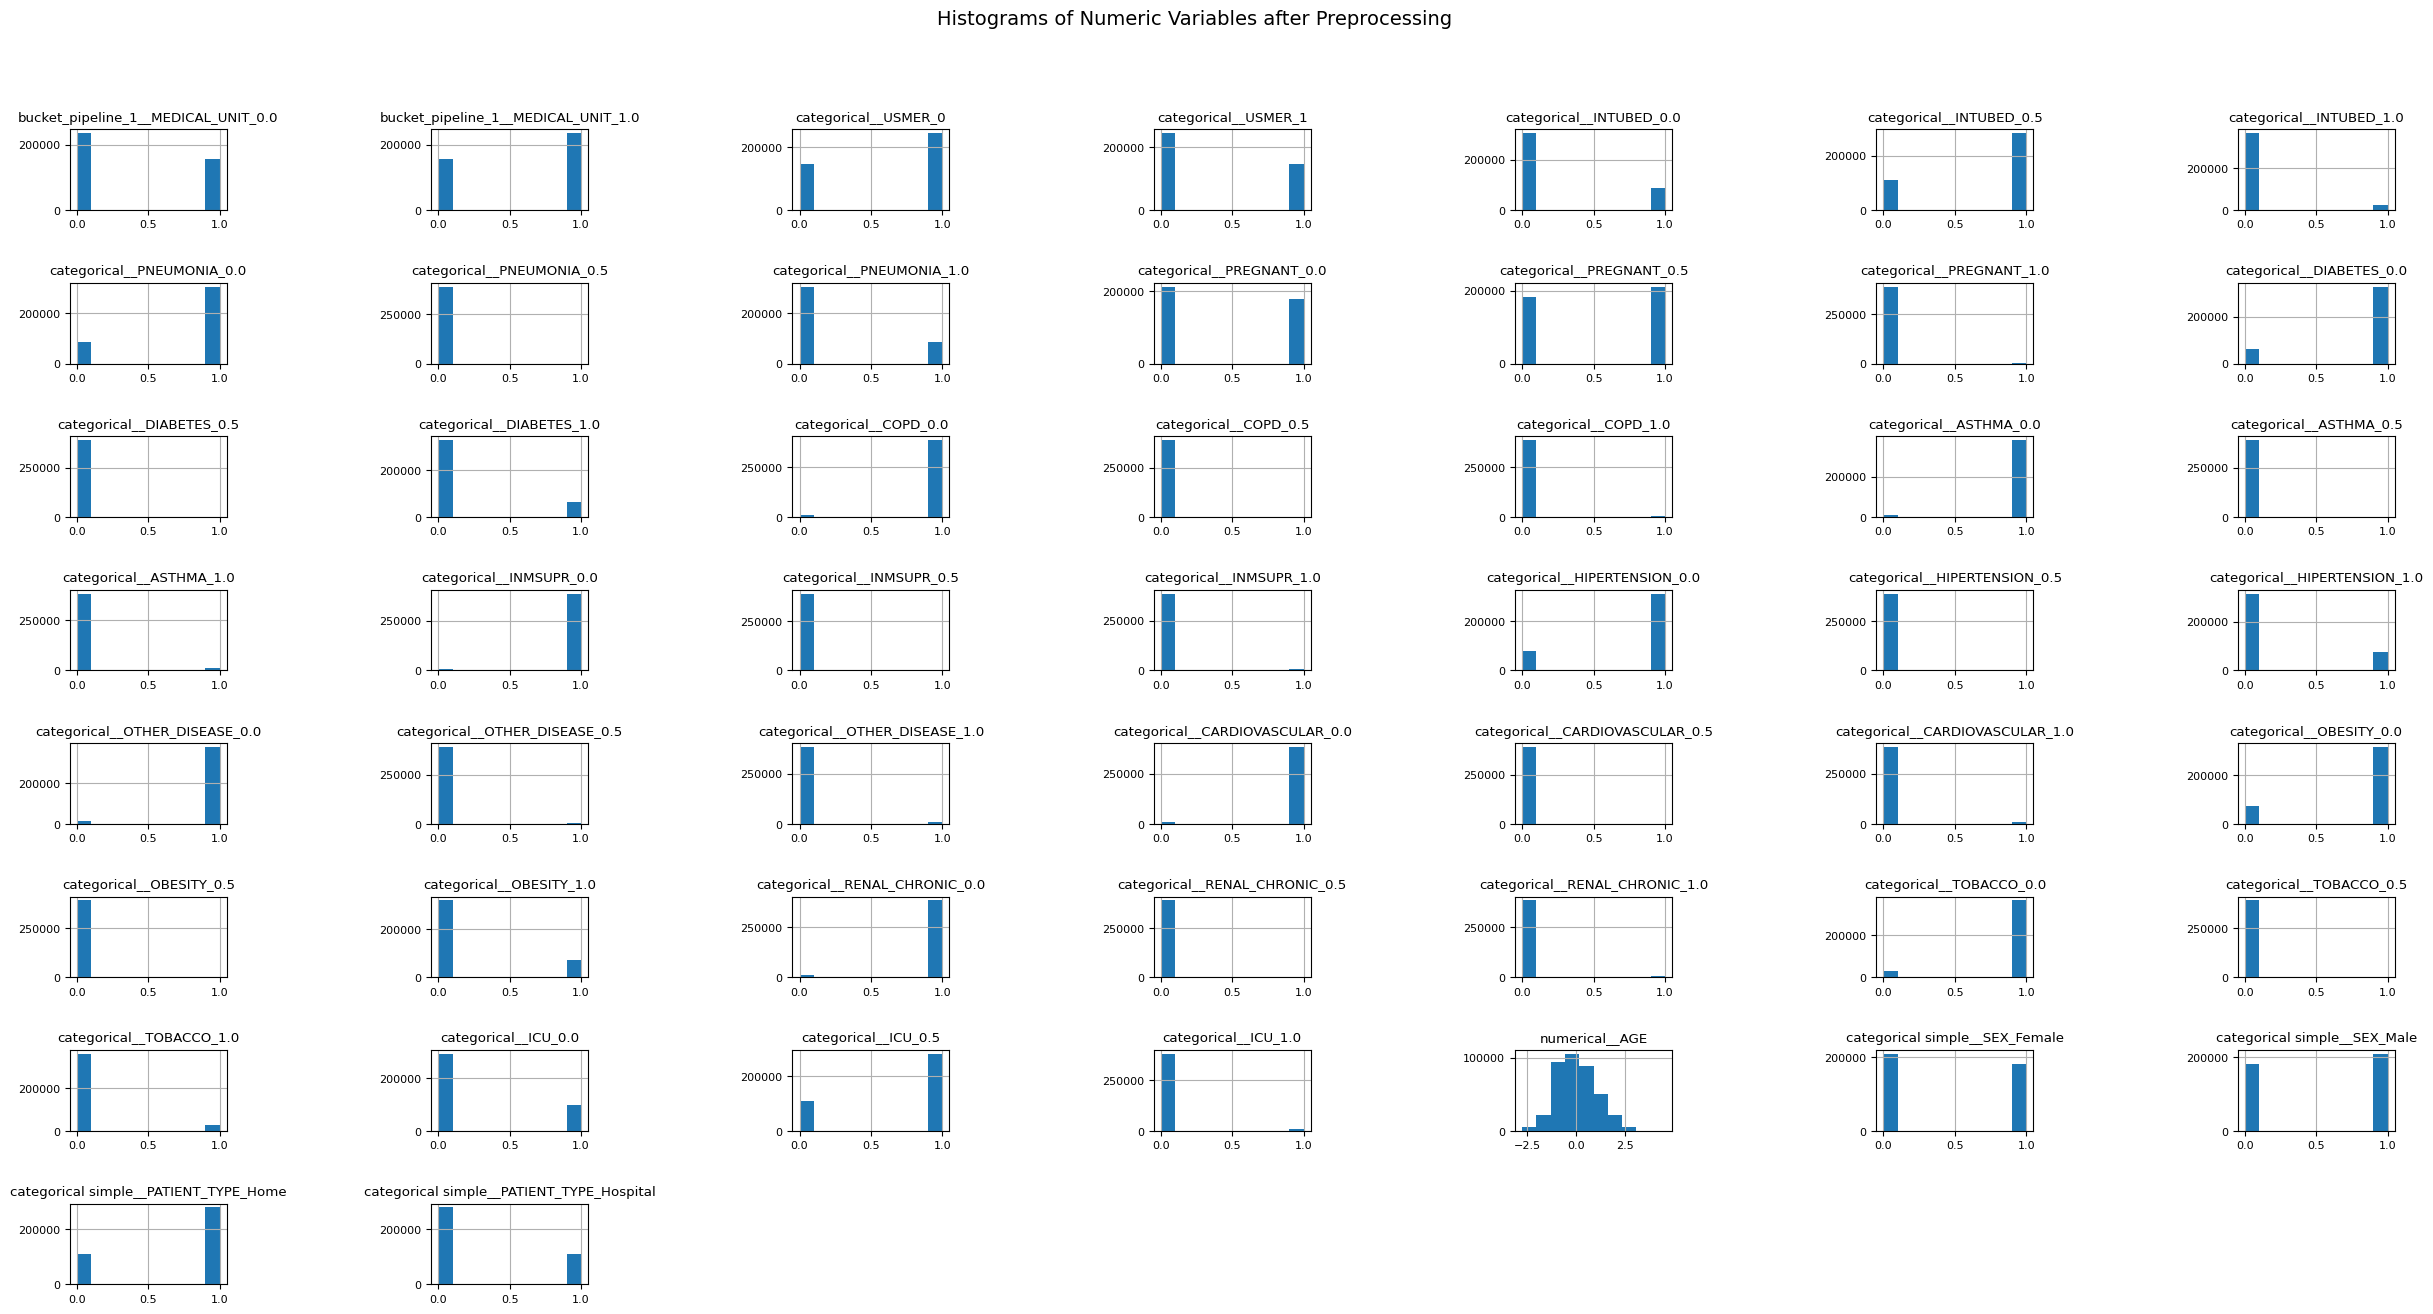

In [93]:
##let's look at the histograms
plt.figure(figsize=(20,10))
covid_pip_prep.hist(figsize=(30,15))
plt.subplots_adjust(hspace=0.9, wspace=1.3)
plt.suptitle("Histograms of Numeric Variables after Preprocessing", fontsize=14, y=0.96)
plt.rcParams.update({'font.size': 10})
plt.show()

Great! Before proceeding any further, let us define an evaluation metric

## <a id='section4_2'></a>Evaluation Metric

In [94]:
##let us import the metrics used for the evaluation function. I will make use of Scikit-Learn for this
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score, f1_score, precision_score, recall_score, accuracy_score


## Evaluation function that defines the metrics to be used for evaluating the models
##this function assumes that the model has already been fitted to the training data
def evaluation_metric(model, xTrain, yTrain, xTest, yTest):

    ##predict the labels on the training data
    yTrain_pred = model.predict(xTrain)

    ##predict the labels on the test data
    yTest_pred = model.predict(xTest)


    ##now I can calculate cross validation scores for the prediction on the test set and training set

    ##cross validation scores for the training set. cv=5 means 5-fold cross validation ( there are 5 folds used for cross validation)
    scores_train = cross_val_score(model, xTrain, yTrain, cv=5)
    mean_cv_train = scores_train.mean()
    print("-"*100)
    print("The mean cross validation score on the training set is:", mean_cv_train)


    ##cross validation scores for the test set
    scores_test = cross_val_score(model, xTest, yTest, cv=5)
    mean_cv_test = scores_test.mean()
    print("-"*100)
    print("The mean cross validation score on the test set is:", mean_cv_test)
 

    ##overfitting/underfitting measure
    print("-"*100)
    print("The difference between the mean cross validation scores on the training and test data:", mean_cv_train - mean_cv_test)


    ##fpr is the false positive rate, tpr is the true positive rate
    ##The roc_curve method calculates the aforemntioned rates for different thresholds and plot the results based on the test labels and the predicted labels
    ## We first must calculate the probabilities of the positive class
    yTest_prob = model.predict_proba(xTest)[:,1]
    fpr, tpr, thresholds = roc_curve(yTest, yTest_prob)
    ## the roc_curve method requires the second argument to be either probability estimates of the positive class, confidence values, or non-thresholded measure of decisions
    ## the roc_curve below used the probability estimates of the positive class as given by the predict_proba method (yTest_prob)
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, linewidth=2, label="ROC curve")
    plt.plot([0, 1], [0, 1], "k--", label="Random classifier's ROC curve")
    plt.xlabel("False positive rate")
    plt.ylabel("True positive rate")
    plt.title("ROC curve")
    plt.legend()
    plt.show()


    ##the AUC score is the area under the ROC curve
    auc_score = roc_auc_score(yTest, yTest_prob)
    print("-"*100)
    print("The AUC score is:", auc_score)

    ##accuracy score of predictions
    acc_score = accuracy_score(yTest, yTest_pred)
    print("-"*100)
    print("The accuracy score is:", acc_score)


    ##true negative rate
    print("-"*100)
    tn, fp, fn, tp = confusion_matrix(yTest, yTest_pred).ravel()
    tnr = tn / (tn+fp)
    print("The true negative rate (TNR) is:", tnr)

    ##true positive rate
    print("-"*100)
    tn, fp, fn, tp = confusion_matrix(yTest, yTest_pred).ravel()
    tpr = tp / (tp+fn)
    print("The true positive rate (TPR) is:", tpr)

    ##recall score of predictions
    rec_score = recall_score(yTest, yTest_pred)
    print("-"*100)
    print("The recall score is:", rec_score)


    ##confusion matrix
    print("-"*100)
    cm = confusion_matrix (yTest, yTest_pred)
    ##now let us put it into a dataframe
    cm_df = pd.DataFrame(cm, columns=["Predicted negative", "Predicted positive"], index=["Actual negative", "Actual positive"])
    ##plot the confusion matrix via seaborn
    sns.heatmap(cm_df, annot=True, fmt="d")
    plt.title("Confusion matrix")
    plt.show()

Notes on the Evaluation Metric:

1. The cross-validation scores on the training set and on the test set are calculated to see if the model overfits or underfits. If there is overfit, the model _learns more_ on the training set than on the test set, which means that the function it creates is less reliable on new data. Hence, overfit can be detected by a higher cross validation score on the training set than on the test set. If the opposite is true (there is a lower score on the training set) there is a degree of underfit. 
2. The AUC is the area under the ROC curve, a graph showing the dependence of the true positive rate on the true negative rate for all possible threholds. A classifier that distinguishes perfectly has an AUC of 1, while a classifier that is truly random has an AUC of 0.5 (interpreted as 50% probability of being any of the classes). For this project, AUC must be as high as possible
3. The TPR (true positive rate) is calculated from the values of the confusion matrix as  $TP/(TP+FN)$ where TP are correct prediction of positive cases (True Positives) and FN are misclassifed cases of positive (high risk) patients (False Negatives). It is crucial for this project to achieve a high TPR as this is the probability of a patient classified as high risk to be really at high risk. 
4. Accuracy represents the percentage of correct predictions. Accuracy should be as high as possible and consistent for different training data. 

## <a id='section4_2'></a>Create New Variables for the Data

Finally, let us pre-process the training and test data, now sampled on the entirety of the dataset. I will use this when I do the final test for the best performing model.

In [95]:
xTrain = preprocessing.fit_transform(train)
y = train["Higher_Risk"]
X = pd.DataFrame(xTrain, columns=preprocessing.get_feature_names_out(), index=train.index)
xTest = preprocessing.fit_transform(test)
yy = test["Higher_Risk"]
XX = pd.DataFrame(xTest, columns=preprocessing.get_feature_names_out(), index=test.index)

In [96]:
print(X.shape) 
print(XX.shape)

(313583, 51)
(78396, 51)


In [97]:
print(y.shape)
print(yy.shape)

(313583,)
(78396,)


#  <a id='section5'></a>5. Train Machine Learning Models

The aim of this section is to test as many Machine Learning models as possible, to understand which performs better in terms of accuracy, recall and AUC ( all these metrics are self-consistent, but recall is very important for confidence in the predictions). At this stage in the workflow, I am not expecting to get good performance, but rather to see which model performs best on imbalanced classes. Once I find a model, I can use undersampling techniques to improve its performance.

## <a id='section5_1'></a>Dummy Classifier

Let us first see the Dummy Classifier, which classifies completely at random. This is the worst possible classifier, but looking at it might offer insights into how well other models are performing.

----------------------------------------------------------------------------------------------------
The mean cross validation score on the training set is: 0.8616347187408738
----------------------------------------------------------------------------------------------------
The mean cross validation score on the test set is: 0.8616383492934133
----------------------------------------------------------------------------------------------------
The difference between the mean cross validation scores on the training and test data: -3.63055253949085e-06


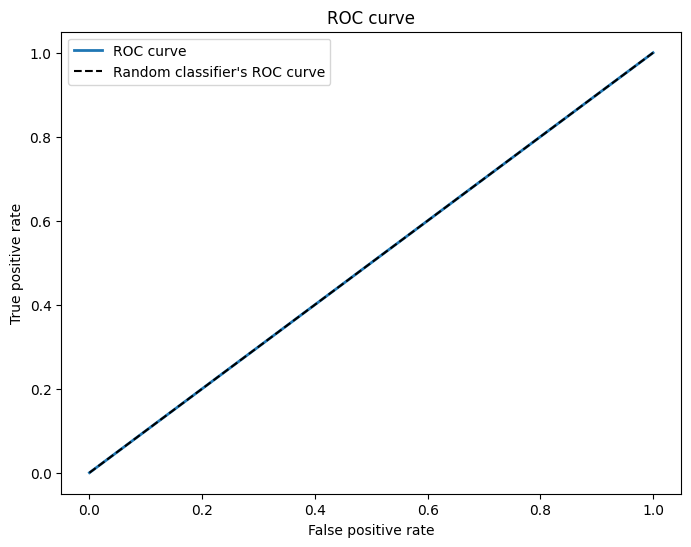

----------------------------------------------------------------------------------------------------
The AUC score is: 0.5
----------------------------------------------------------------------------------------------------
The accuracy score is: 0.8616383488953518
----------------------------------------------------------------------------------------------------
The true negative rate (TNR) is: 1.0
----------------------------------------------------------------------------------------------------
The true positive rate (TPR) is: 0.0
----------------------------------------------------------------------------------------------------
The recall score is: 0.0
----------------------------------------------------------------------------------------------------


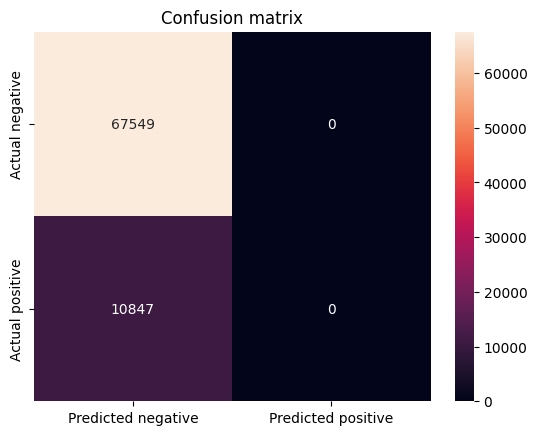

In [98]:
from sklearn.dummy import DummyClassifier
dummy = DummyClassifier().fit(X, y)
evaluation_metric(dummy, X, y, XX, yy)

Observe:

- the model does not detect any positives, so it is not really a classifier
- Accuracy 86% means it is very bad because 86% is the number of lower risk patients in the dataset (the dummy classifier guesses randomly)

Note: All subsequent models should have performance metrics as far as possible (higher) than the random classifier. Anything performing simillar to the Dummy Classifier is clearly a bad model

## <a id='section5_2'></a> SGD Classifier

In [99]:
from sklearn.linear_model import SGDClassifier

In the following, I will use Bayesian optimization to find the best parameters for the model.

In [100]:
##imports bayes search cv
from skopt import BayesSearchCV

In [101]:
##let's define the hyperparameter space
search_space = {
    'alpha': (0.0001, 0.01, 'log-uniform'),
    'max_iter': (100, 1000),
    'penalty': ['l1', 'l2', 'elasticnet'],
    'l1_ratio': (0, 1.0),
    'learning_rate': ['constant', 'optimal', 'invscaling', 'adaptive'],
    'eta0': (0.01, 1.0, 'log-uniform'),
    'power_t': (0.1, 0.9),
    'early_stopping': [True, False],
}

In [102]:
## now, let us start searching
opt = BayesSearchCV(
    SGDClassifier(),
    search_space,
        n_iter=32,
    random_state=1923
)

opt.fit(X, y)

print("val. score: %s" % opt.best_score_)
print("test score: %s" % opt.score(X, y))
print("Best parameters: ", opt.best_params_)

val. score: 0.9077851846993654
test score: 0.9089013116144689
Best parameters:  OrderedDict([('alpha', 0.00013946498668087882), ('early_stopping', False), ('eta0', 0.014763068316927273), ('l1_ratio', 0.6912218141776066), ('learning_rate', 'constant'), ('max_iter', 211), ('penalty', 'l2'), ('power_t', 0.5006359285631012)])


In [103]:
##instantiating the model with the best parameters found by the search
sgd_clf = SGDClassifier(alpha= 0.00014, eta0=0.014, l1_ratio=0.69, learning_rate='constant',  loss="log_loss", max_iter=211, penalty="l2", power_t=0.5, random_state=1923)    

----------------------------------------------------------------------------------------------------
The mean cross validation score on the training set is: 0.9120647484533991
----------------------------------------------------------------------------------------------------
The mean cross validation score on the test set is: 0.9105949812956625
----------------------------------------------------------------------------------------------------
The difference between the mean cross validation scores on the training and test data: 0.0014697671577366123


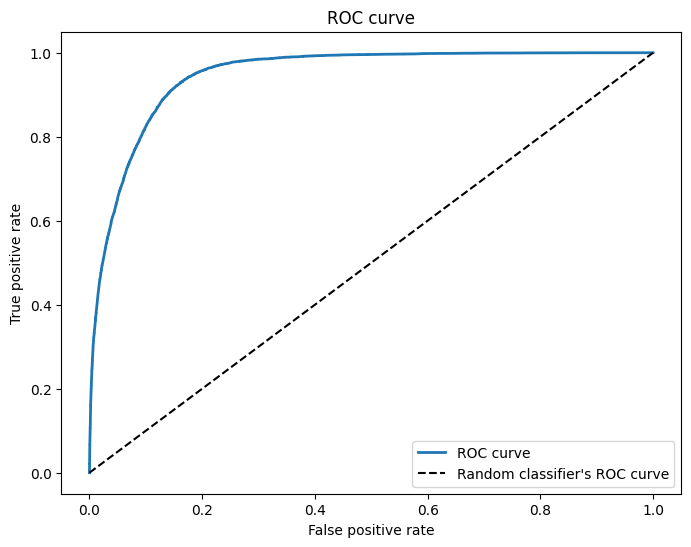

----------------------------------------------------------------------------------------------------
The AUC score is: 0.9471143622235677
----------------------------------------------------------------------------------------------------
The accuracy score is: 0.9108245318638706
----------------------------------------------------------------------------------------------------
The true negative rate (TNR) is: 0.9742409214052021
----------------------------------------------------------------------------------------------------
The true positive rate (TPR) is: 0.5159030146584309
----------------------------------------------------------------------------------------------------
The recall score is: 0.5159030146584309
----------------------------------------------------------------------------------------------------


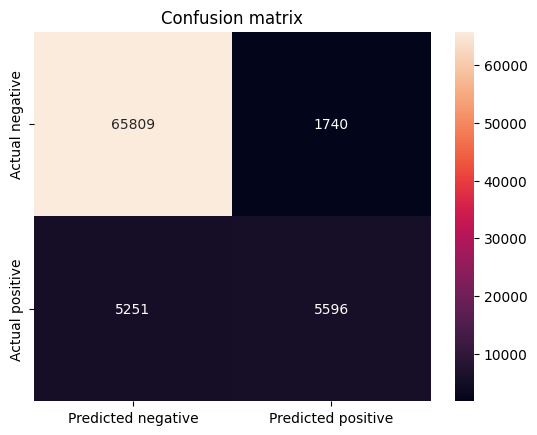

In [104]:
##fit and evaluate model
sgd_clf.fit(X, y)
evaluation_metric(sgd_clf, X, y, XX, yy)

Observations: 

- TPR is around 50%, which mean that half of the positive predictions are wrong ( this is seen in the confussion matrix)
- Accuracy is 91%, which is better than that of a random classifier 

## <a id='section5_3'></a>RandomForest Classifer

Let's try a RandomForest Classifier and evaluate its performance

In [105]:
from sklearn.ensemble import RandomForestClassifier

In [106]:
##Hyperparameter search with BayesSearchCV

opt_rf = BayesSearchCV(
        RandomForestClassifier(),
        {
        'n_estimators': [100, 200, 300, 400, 500],
        'max_depth': [None, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50],
        'max_features': ['sqrt', 'log2'],
        },
        n_iter=3,
        random_state=1923)

##let's fit each model to the training data
opt_rf.fit(X, y)

##let's print the best score and the best parameters
print("val. score: %s" % opt_rf.best_score_)
print("Best parameters: ", opt_rf.best_params_)

val. score: 0.9065638084797912
Best parameters:  OrderedDict([('max_depth', 5), ('max_features', 'log2'), ('n_estimators', 100)])


In [107]:
##Let's instantiate the random forest classifier with the best parameters found by the hyperparameter search
rf_clf = RandomForestClassifier(max_depth= 5, max_features='log2', n_estimators= 100, random_state=1923)

----------------------------------------------------------------------------------------------------
The mean cross validation score on the training set is: 0.9067296372125135
----------------------------------------------------------------------------------------------------
The mean cross validation score on the test set is: 0.9067044677268828
----------------------------------------------------------------------------------------------------
The difference between the mean cross validation scores on the training and test data: 2.5169485630693877e-05


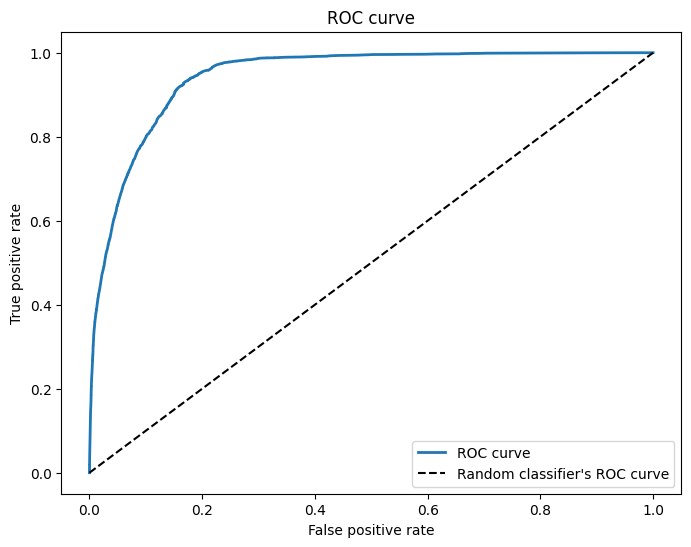

----------------------------------------------------------------------------------------------------
The AUC score is: 0.9435426845893731
----------------------------------------------------------------------------------------------------
The accuracy score is: 0.9064493086381958
----------------------------------------------------------------------------------------------------
The true negative rate (TNR) is: 0.9823535507557477
----------------------------------------------------------------------------------------------------
The true positive rate (TPR) is: 0.43376048677053564
----------------------------------------------------------------------------------------------------
The recall score is: 0.43376048677053564
----------------------------------------------------------------------------------------------------


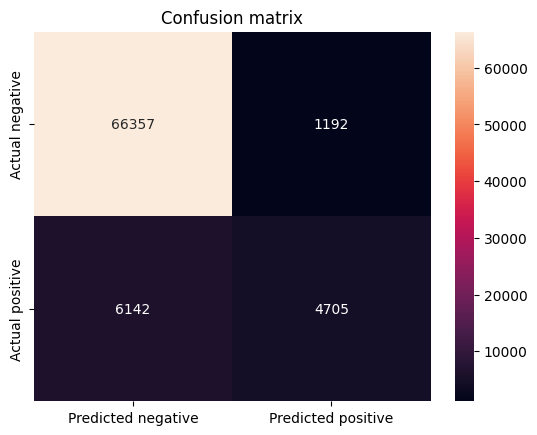

In [108]:
##Let's fit the model to the training data and the evaluate it on the validation set
rf_clf.fit(X, y)
evaluation_metric(rf_clf, X, y, XX, yy)

Observe :

- There is clealry no overfit or underfit, judging by the mean cross validation scores on the training and validation set
- The TPR close to 43% indicates low confidence in the positives in detects
- accuracy of 90% is quite low, given the imbalance of this dataset

## <a id='section5_4'></a>Logistic Regression

In [109]:
from sklearn.linear_model import LogisticRegression

In [110]:
opt_log = BayesSearchCV(
        LogisticRegression(),
        { 'C' : (0.0001, 10.0, 'log-uniform'),
        'penalty' : ['l1', 'l2'],
        'solver' : ['liblinear', 'saga'],
        'max_iter' : [1000, 2000, 3000, 4000, 5000]},
        n_iter=3, 
        random_state=1923)

opt_log.fit(X, y)
print("val. score: %s" % opt_log.best_score_)
print("Best parameters: ", opt_log.best_params_)

val. score: 0.9128811234896744
Best parameters:  OrderedDict([('C', 0.04067517192324702), ('max_iter', 3000), ('penalty', 'l1'), ('solver', 'liblinear')])


Let us try these hyper-parameters to instantiate a models

In [111]:
log_clf = LogisticRegression(C= 0.04, max_iter= 3000, penalty= 'l1', solver= 'liblinear', random_state=1923)

----------------------------------------------------------------------------------------------------
The mean cross validation score on the training set is: 0.9129066350665506
----------------------------------------------------------------------------------------------------
The mean cross validation score on the test set is: 0.911207227007137
----------------------------------------------------------------------------------------------------
The difference between the mean cross validation scores on the training and test data: 0.0016994080594135985


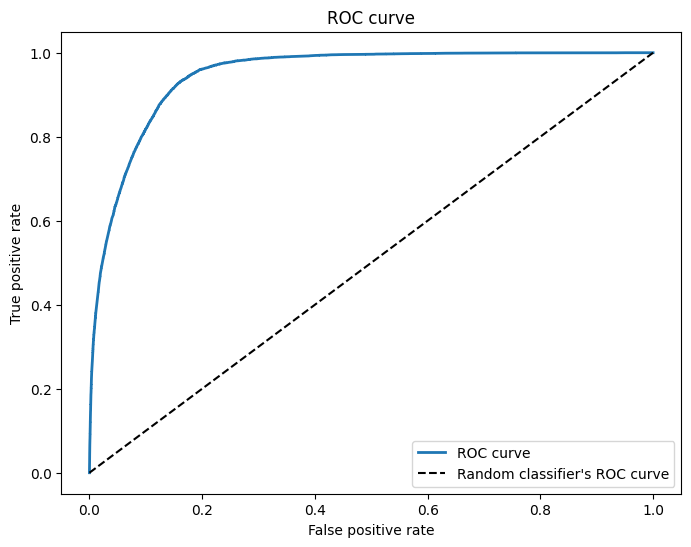

----------------------------------------------------------------------------------------------------
The AUC score is: 0.9476243471540033
----------------------------------------------------------------------------------------------------
The accuracy score is: 0.9117557018215215
----------------------------------------------------------------------------------------------------
The true negative rate (TNR) is: 0.9641297428533361
----------------------------------------------------------------------------------------------------
The true positive rate (TPR) is: 0.5855997049875542
----------------------------------------------------------------------------------------------------
The recall score is: 0.5855997049875542
----------------------------------------------------------------------------------------------------


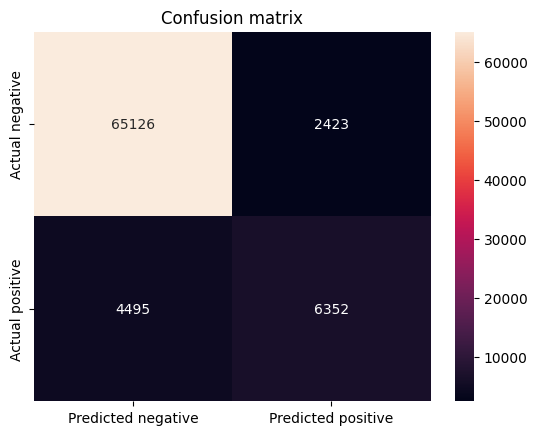

In [112]:
##now train and evaluate the model
log_clf.fit(X, y)
evaluation_metric(log_clf, X, y, XX, yy)

Observe:

- True positive rate is at around 58.5%, which is the highest so far

## <a id='section5_5'></a>Nearest Neighbours Classifier

In [113]:
from sklearn.neighbors import KNeighborsClassifier

In [114]:
opt_knn = BayesSearchCV(
        KNeighborsClassifier(),
        {'n_neighbors': [10, 20, 30, 50],
         'weights': ['uniform', 'distance'],
         'metric': ['euclidean', 'manhattan'],
         'algorithm':  ['auto', 'ball_tree', 'kd_tree', 'brute']},
        n_iter=3,
        random_state=1923)

opt_knn.fit(X, y)
print("val. score: %s" % opt_knn.best_score_)
print("Best parameters: ", opt_knn.best_params_)

val. score: 0.9077341572744553
Best parameters:  OrderedDict([('algorithm', 'auto'), ('metric', 'euclidean'), ('n_neighbors', 10), ('weights', 'uniform')])


Note: It took about 8 minutes to find the best hyperparameters on an M2 Macbook. According to Bayes Search Cross Validation the best algorithm is 'auto', the distance measure is 'euclidean', it has 10 nearest neighbours and the weights are uniform. Let us instantiate a model with these metrics and see how well it performs given our evaluation function.

In [115]:
##instantiating the model with the best parameters found by the BayesSearchCV hyperparameter search
knn_clf = KNeighborsClassifier(algorithm= 'auto', metric= 'euclidean', n_neighbors= 10, weights= 'uniform')

----------------------------------------------------------------------------------------------------
The mean cross validation score on the training set is: 0.9077341572744553
----------------------------------------------------------------------------------------------------
The mean cross validation score on the test set is: 0.9045614649648366
----------------------------------------------------------------------------------------------------
The difference between the mean cross validation scores on the training and test data: 0.0031726923096186965


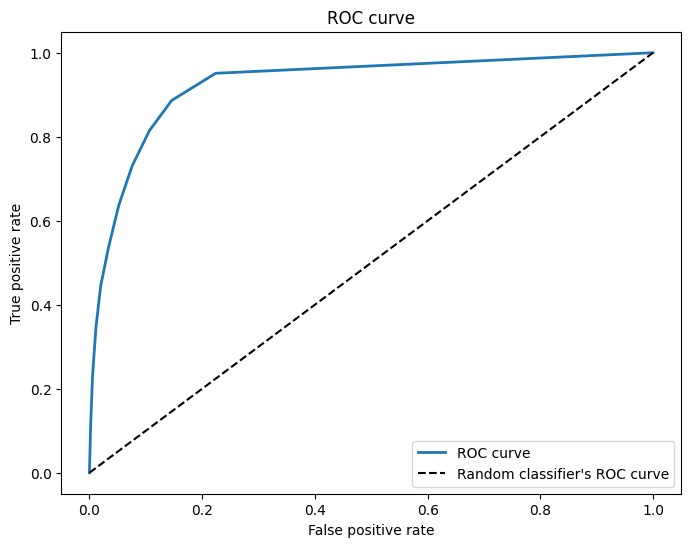

----------------------------------------------------------------------------------------------------
The AUC score is: 0.9255236107943032
----------------------------------------------------------------------------------------------------
The accuracy score is: 0.9067299352007756
----------------------------------------------------------------------------------------------------
The true negative rate (TNR) is: 0.9661282920546567
----------------------------------------------------------------------------------------------------
The true positive rate (TPR) is: 0.5368304600350328
----------------------------------------------------------------------------------------------------
The recall score is: 0.5368304600350328
----------------------------------------------------------------------------------------------------


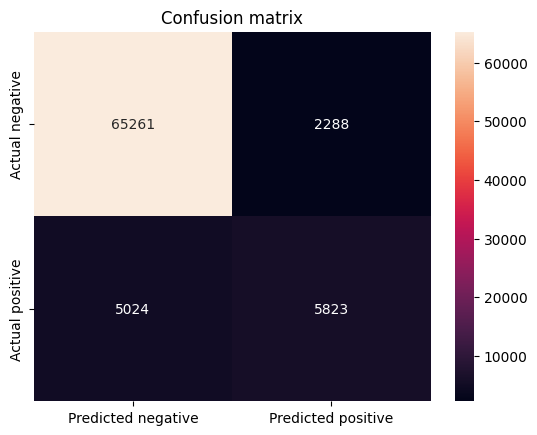

In [116]:
##let us fit and evaluate the model
knn_clf.fit(X, y)
evaluation_metric(knn_clf, X, y, XX, yy)

Observe: 

- Performance is lower than logistic regression

## <a id='section5_6'></a>MultiLayer Perceptron

Let us train an MLP model to see if it performs better than the previous ones

In [117]:
from sklearn.neural_network import MLPClassifier

In [118]:
##Hyperparameter search with BayesSearchCV

opt_mlp = BayesSearchCV(
        MLPClassifier(),
        {
        'activation': ['relu', 'tanh', 'logistic'], 
         'solver': ['adam', 'sgd'], 
        'alpha': [0.001, 0.01, 0.1], 
        'learning_rate': ['constant',  'adaptive']},
        n_iter=3,
        random_state=1923)

##let's fit each mlp model to the training data
opt_mlp.fit(X, y)

##let's print the best score and the best parameters
print("val. score: %s" % opt_mlp.best_score_)
print("Best parameters: ", opt_mlp.best_params_)

val. score: 0.9145553235759613
Best parameters:  OrderedDict([('activation', 'relu'), ('alpha', 0.01), ('learning_rate', 'constant'), ('solver', 'adam')])


Let's use these hyperparams to instantiate, train and evaluate the model

In [119]:
##instantiating the model with the best parameters found by the hyperparameter search
mlp_clf = MLPClassifier(activation= 'relu', alpha= 0.01, learning_rate= 'constant', solver= 'adam', random_state=1923)

----------------------------------------------------------------------------------------------------
The mean cross validation score on the training set is: 0.9141567044690572
----------------------------------------------------------------------------------------------------
The mean cross validation score on the test set is: 0.9120108350438842
----------------------------------------------------------------------------------------------------
The difference between the mean cross validation scores on the training and test data: 0.0021458694251729193


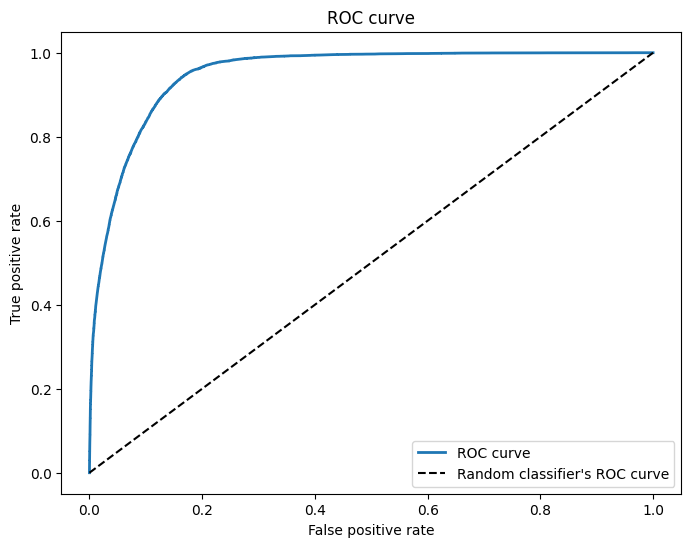

----------------------------------------------------------------------------------------------------
The AUC score is: 0.9509310043990574
----------------------------------------------------------------------------------------------------
The accuracy score is: 0.9135797744782898
----------------------------------------------------------------------------------------------------
The true negative rate (TNR) is: 0.9629898296051755
----------------------------------------------------------------------------------------------------
The true positive rate (TPR) is: 0.6058818106388864
----------------------------------------------------------------------------------------------------
The recall score is: 0.6058818106388864
----------------------------------------------------------------------------------------------------


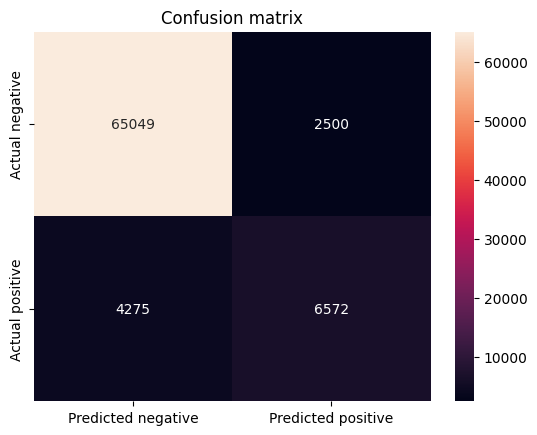

In [120]:
##fit and evaluate the model
mlp_clf.fit(X, y)
evaluation_metric(mlp_clf, X, y, XX, yy)

Observe:

- The TPR is the highest at 60.58%
- The better TPR score is also reflected in the higher AUC score
- Accuracy is slightly higher than other models at 91%
- Even so, over 4000 high risk patients are misclassified

<a id='section5_7'></a>
## XGBoost

I'll try the XGBoost library, which is based on using parallel trees. I found the [documentation](https://xgboost.readthedocs.io/en/stable/get_started.html) quite useful.

In [121]:
##import the XGBoost classifier
from xgboost import XGBClassifier

As before, let's run a parameter search with BayesCV and see what is the best performance obtained with XGBoost

In [122]:
opt_xgb = BayesSearchCV(
        XGBClassifier(),
        {'n_estimators': [100, 200, 300, 400, 500],
        'eta': [0.01, 0.1, 1.0], 
         'gamma': [0, 10, 100], 
        'max_depth': [3, 5, 7, 9], 
        'sampling_method': ['uniform',  'gradient_based'],
        'lambda' : [0.01, 0.1, 0.5, 1.0], ##L2 regularization term on weights
        'alpha' : [0.01, 0.1, 0.5, 1.0], ##L1 regularization term on weights
        'grow_policy' : ['depthwise', 'lossguide']
         }, ##controls the way trees are grown
        n_iter=3,
        random_state=1923)

##let's fit each the XGB classifier model to the training data
opt_xgb.fit(X, y) ##as before, optimize the model on the imbalanced data 

##let's print the best score and the best parameters
print("val. score: %s" % opt_xgb.best_score_)
print("Best parameters: ", opt_xgb.best_params_)

val. score: 0.9145872116360488
Best parameters:  OrderedDict([('alpha', 0.01), ('eta', 0.1), ('gamma', 0), ('grow_policy', 'lossguide'), ('lambda', 0.1), ('max_depth', 3), ('n_estimators', 500), ('sampling_method', 'uniform')])


In [123]:
##the best parameter were found in a value dictionary as above
opt_xgb.best_params_

OrderedDict([('alpha', 0.01),
             ('eta', 0.1),
             ('gamma', 0),
             ('grow_policy', 'lossguide'),
             ('lambda', 0.1),
             ('max_depth', 3),
             ('n_estimators', 500),
             ('sampling_method', 'uniform')])

In [181]:
##create model instance with the best parameters
xgb_clf = XGBClassifier(n_estimators=500, max_depth=3, learning_rate=0.1, objective='binary:logistic', sampling_method='uniform', grow_policy='lossguide', alpha=0.01, gamma=0,  random_state=1923)

In [182]:
##fit the model
xgb_clf.fit(X, y)

XGBClassifier(alpha=0.01, base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0, grow_policy='lossguide', importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=500, n_jobs=None,
              num_parallel_tree=None, ...)

----------------------------------------------------------------------------------------------------
The mean cross validation score on the training set is: 0.9145776449536175
----------------------------------------------------------------------------------------------------
The mean cross validation score on the test set is: 0.9124827917167249
----------------------------------------------------------------------------------------------------
The difference between the mean cross validation scores on the training and test data: 0.0020948532368926243


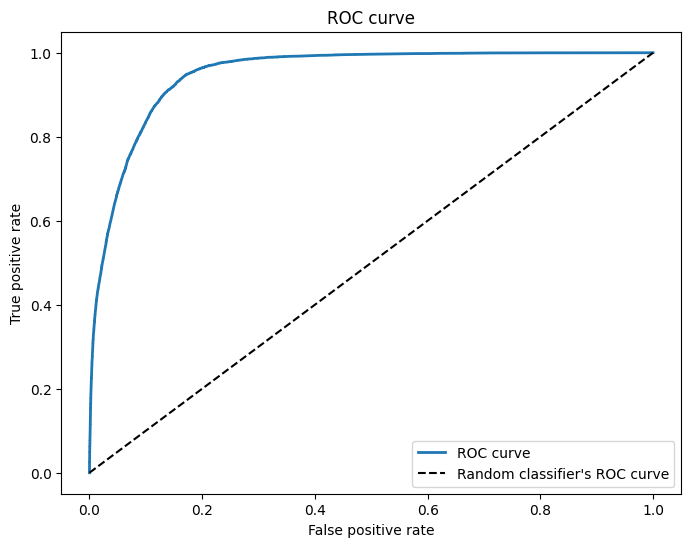

----------------------------------------------------------------------------------------------------
The AUC score is: 0.949853640283715
----------------------------------------------------------------------------------------------------
The accuracy score is: 0.9122786876881473
----------------------------------------------------------------------------------------------------
The true negative rate (TNR) is: 0.963093458082281
----------------------------------------------------------------------------------------------------
The true positive rate (TPR) is: 0.5958329492025445
----------------------------------------------------------------------------------------------------
The recall score is: 0.5958329492025445
----------------------------------------------------------------------------------------------------


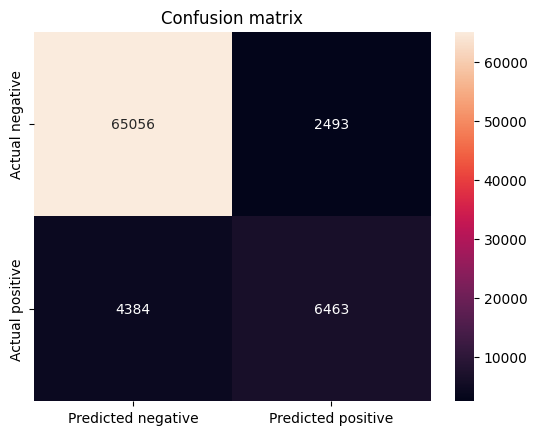

In [183]:
##evaluate the model
evaluation_metric(xgb_clf, X, y, XX, yy)

Observe :

- compared to random forest, XGBoost performs quite well qith 59.5% TPR
- it is also very close to the MLP performance
- Accuracy is still around 91%

# <a id='section6'></a>6. Voting Classifier

In this section, I will attempt an alternative way of ensemble learning, which is the voting classifier. The aim is to combine several "weaker" learners to see if I can obtain a significantly stronger learner. To maximise the performance of the voting classifiers, I will select the top 3 performing models: MLP, Logistic Regression and XGBoosting. There are two main options forvoting classifiers : (i) a hard voting one (majority wins) and a soft voting classifier (combines probabilities). As hard voting has no predict_proba method, the evaluation metric I chose will not be able to evaluate the recall, which is crucial for this model. Hence, I will use a soft voting approach

## <a id='section6_1'></a>Soft Voting

In [127]:
from sklearn.ensemble import VotingClassifier

In [184]:
##create instance of voting classifier
##creates an instance of the voting classifier with soft voting
voting_soft = VotingClassifier(estimators=[
                                            ('log', log_clf), 
                                           ('mlp', mlp_clf),
                                            ('xgb', xgb_clf),
                                            ], 
                                            voting='soft')

In [185]:
voting_soft.fit(X, y) 

VotingClassifier(estimators=[('log',
                              LogisticRegression(C=0.04, max_iter=3000,
                                                 penalty='l1',
                                                 random_state=1923,
                                                 solver='liblinear')),
                             ('mlp',
                              MLPClassifier(alpha=0.01, random_state=1923)),
                             ('xgb',
                              XGBClassifier(alpha=0.01, base_score=None,
                                            booster=None, callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None, device=None,
                                            early_stopping_...
                                            grow_policy='lossguide',
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_rate=0.1, max_bin=None,
                                            max_cat_threshold=None,
                                            max_cat_to_onehot=None,
                                            max_delta_step=None, max_depth=3,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=500, n_jobs=None,
                                            num_parallel_tree=None, ...))],
                 voting='soft')

----------------------------------------------------------------------------------------------------
The mean cross validation score on the training set is: 0.914405441466486
----------------------------------------------------------------------------------------------------
The mean cross validation score on the test set is: 0.912457270936948
----------------------------------------------------------------------------------------------------
The difference between the mean cross validation scores on the training and test data: 0.0019481705295379959


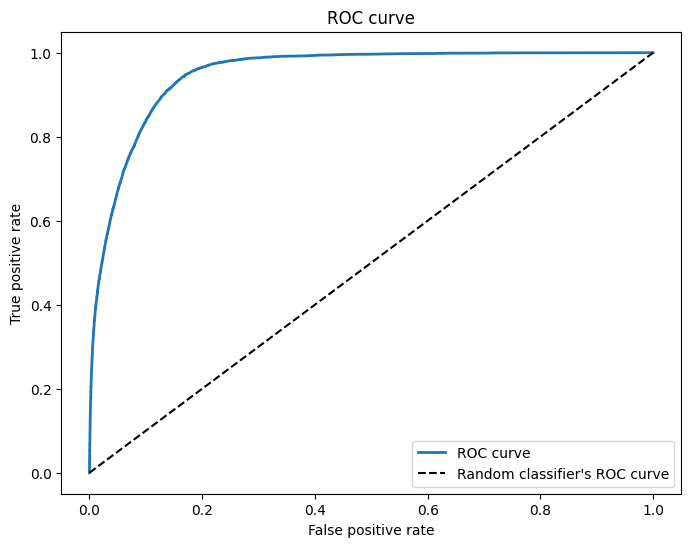

----------------------------------------------------------------------------------------------------
The AUC score is: 0.9506131338823873
----------------------------------------------------------------------------------------------------
The accuracy score is: 0.9130185213531302
----------------------------------------------------------------------------------------------------
The true negative rate (TNR) is: 0.9649587706701802
----------------------------------------------------------------------------------------------------
The true positive rate (TPR) is: 0.5895639347284963
----------------------------------------------------------------------------------------------------
The recall score is: 0.5895639347284963
----------------------------------------------------------------------------------------------------


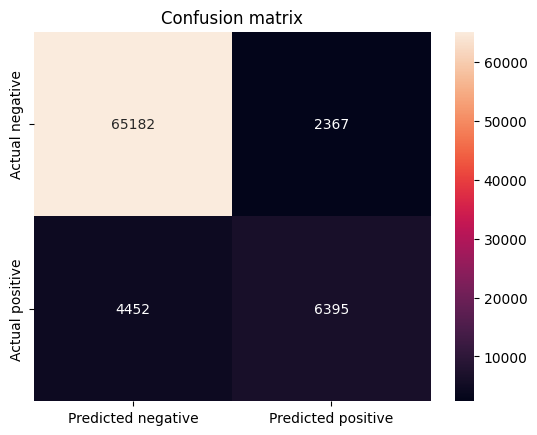

In [186]:
evaluation_metric(voting_soft, X, y, XX, yy)

Observe: 

- The the voting classifier shows simillar performance to the previously individual constituent classifier
- It's TRP is actually worse than that of the MLP 
- In terms of Accuracy, and AUC it not better than the previous ones

<a id='section7'></a>
# 7. Undersampling methods

The previous experiements showed that the MLP classifier gives the best performance on the imbalanced dataset. However, the performance must be siginificantly improved if this classifier should be used. The purpose of this section is to experiement with different undersampling techniques that can create a training set with balanced classes. This could introduce bias by eliminating significant proportions of the majority class, but it can definitely improve the results.

<a id='section7_1'></a>
## 7.1 Random Undersampling

I will use the imbalance learn library in the following. 

In [131]:
## import imblearn library
import imblearn

In [132]:
print(imblearn.__version__)

0.11.0


In [133]:
from imblearn.under_sampling import RandomUnderSampler

##create an instance of the random under sampler
rus = RandomUnderSampler(random_state=1923)

In [134]:
##resample the training data with the random under sampler
X_rus, y_rus = rus.fit_resample(X, y)

##let's check the new shape of the resampled data
print(X_rus.shape, y_rus.shape)

##let's check the new class distribution
print(pd.Series(y_rus).value_counts()/len(y_rus))

(86778, 51) (86778,)
Higher_Risk
0    0.5
1    0.5
Name: count, dtype: float64


In the above, I undersampled the training set such that the proportions are balanced (50/50 cases og high risk and lower risk). While this eliminates some instances, thus introducing bias, it can significantly increase performance on the test set.

In [135]:

##define the classifier model with the best parameters found by the hyperparameter search
mlp_rus = MLPClassifier(activation= 'relu', alpha= 0.01, learning_rate= 'constant', solver= 'adam', random_state=1923)

----------------------------------------------------------------------------------------------------
The mean cross validation score on the training set is: 0.8897186353408338
----------------------------------------------------------------------------------------------------
The mean cross validation score on the test set is: 0.9120108350438842
----------------------------------------------------------------------------------------------------
The difference between the mean cross validation scores on the training and test data: -0.022292199703050408


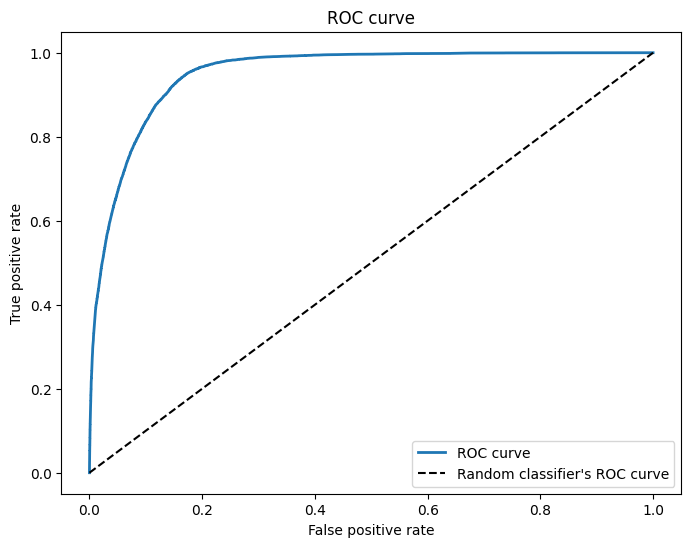

----------------------------------------------------------------------------------------------------
The AUC score is: 0.9504400134961456
----------------------------------------------------------------------------------------------------
The accuracy score is: 0.8548140211235267
----------------------------------------------------------------------------------------------------
The true negative rate (TNR) is: 0.8421442212319945
----------------------------------------------------------------------------------------------------
The true positive rate (TPR) is: 0.9337143910758735
----------------------------------------------------------------------------------------------------
The recall score is: 0.9337143910758735
----------------------------------------------------------------------------------------------------


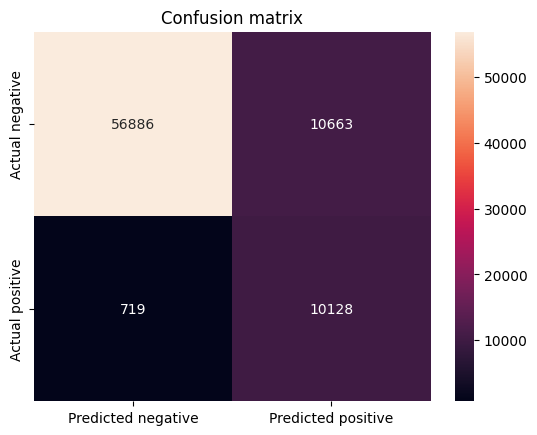

In [136]:
##fit the model to the resampled data
mlp_rus.fit(X_rus, y_rus)

##evaluate the model on the original test set
evaluation_metric(mlp_rus, X_rus, y_rus, XX, yy)

Observe :

- The accuracy score is close to 85%, which is not better than the random classifier
- However, the recall has definitely increased at 93.37% : there are only 719 misclassified High Risk patients, a significant improvement over the previous case where MLP misclassified over 4000 High Risk patients
- The con of using this method, is the large number of False Positives (10663), which is the cost of having reduced the number of misclassified patients
- In sum, although the accuracy is bad, this classifier is far better fit for purpose due to high recall


<a id='section7_2'></a>
## Near-Miss 

In [137]:
from imblearn.under_sampling import NearMiss

In [138]:
##create an instance of the NearMiss algorithm
nm1 = NearMiss(version=1)

In [139]:
## resample the training data with the NearMiss-1
X_nm1, y_nm1 = nm1.fit_resample(X, y)

print(X_nm1.shape, y_nm1.shape)

print(pd.Series(y_nm1).value_counts()/len(y_nm1))

(86778, 51) (86778,)
Higher_Risk
0    0.5
1    0.5
Name: count, dtype: float64


In [140]:
##define the classifier model with the best parameters found by the hyperparameter search
mlp_nm1 = MLPClassifier(activation= 'relu', alpha= 0.01, learning_rate= 'constant', solver= 'adam', random_state=1923)

----------------------------------------------------------------------------------------------------
The mean cross validation score on the training set is: 0.8280670314180598
----------------------------------------------------------------------------------------------------
The mean cross validation score on the test set is: 0.9120108350438842
----------------------------------------------------------------------------------------------------
The difference between the mean cross validation scores on the training and test data: -0.08394380362582443


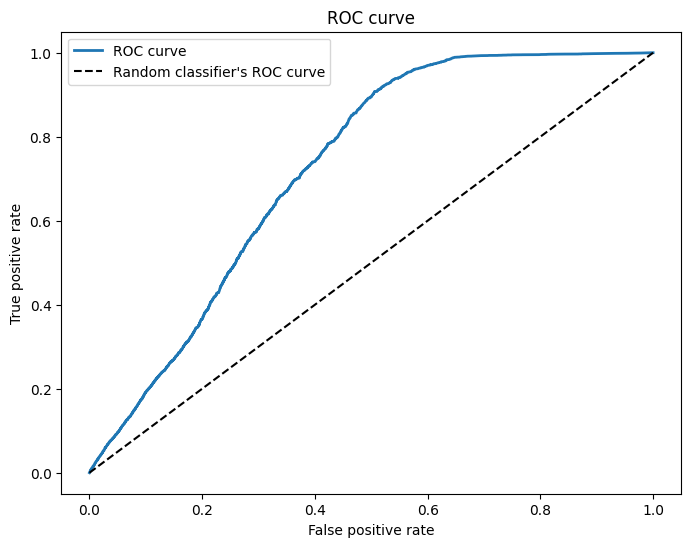

----------------------------------------------------------------------------------------------------
The AUC score is: 0.7257450837210725
----------------------------------------------------------------------------------------------------
The accuracy score is: 0.6008087147303434
----------------------------------------------------------------------------------------------------
The true negative rate (TNR) is: 0.5709484966468785
----------------------------------------------------------------------------------------------------
The true positive rate (TPR) is: 0.7867613164930396
----------------------------------------------------------------------------------------------------
The recall score is: 0.7867613164930396
----------------------------------------------------------------------------------------------------


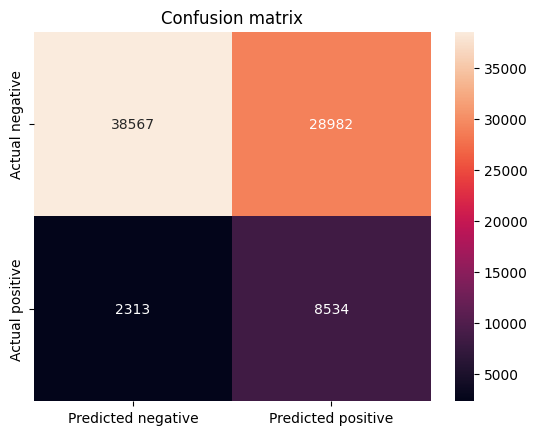

In [141]:
##fit the model to the resampled data
mlp_nm1.fit(X_nm1, y_nm1)

##evaluate the model on the original test set
evaluation_metric(mlp_nm1, X_nm1, y_nm1, XX, yy)

Observe:

- Very bad performance compared to random undersampling
- About 2300 patients high risk patients are misclassified
- Also, a very high number of FP : near 30000. This means most FP predictions are actually false

Note: Undersampling the majority class means removing many relevant information and working with a significantly smaller training set while making predictions on a larger test set. Another possible way to deal with this problem is to oversample the minority class, which will be dealt with in the following section.

<a id='section8'></a>
# 8. Oversampling methods

<a id='section8_1'></a>
## SMOTE

I will use SMOTE methods in the following, a method  that creates a training set with with balanced classes by augmenting the minority class.

In [142]:
from imblearn.over_sampling import SMOTE

In [143]:
smote = SMOTE(random_state=1923)

In [144]:
X_smote, y_smote = smote.fit_resample(X, y)

In [145]:
##define the classifier model with the best parameters found by the hyperparameter search
mlp_smote = MLPClassifier(activation= 'relu', alpha= 0.01, learning_rate= 'constant', solver= 'adam', random_state=1923)

In [146]:
##fit the model to the resampled data
mlp_smote.fit(X_smote, y_smote)

MLPClassifier(alpha=0.01, random_state=1923)

----------------------------------------------------------------------------------------------------
The mean cross validation score on the training set is: 0.891524240647888
----------------------------------------------------------------------------------------------------
The mean cross validation score on the test set is: 0.9120108350438842
----------------------------------------------------------------------------------------------------
The difference between the mean cross validation scores on the training and test data: -0.020486594395996205


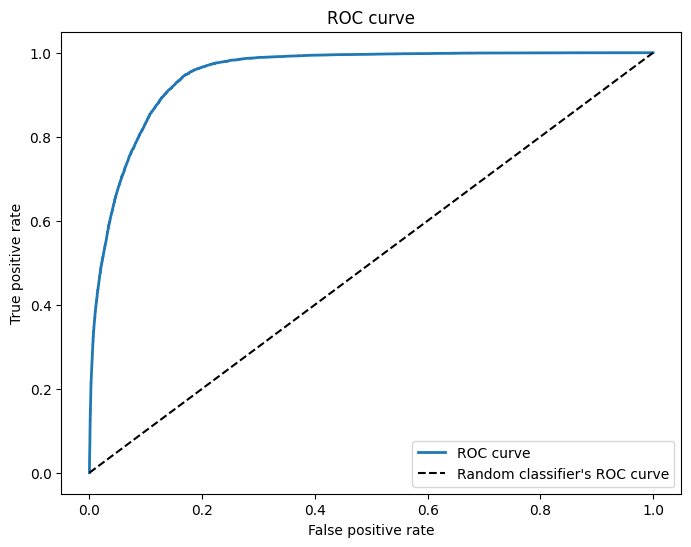

----------------------------------------------------------------------------------------------------
The AUC score is: 0.9504543016670267
----------------------------------------------------------------------------------------------------
The accuracy score is: 0.859967345272718
----------------------------------------------------------------------------------------------------
The true negative rate (TNR) is: 0.849842336674118
----------------------------------------------------------------------------------------------------
The true positive rate (TPR) is: 0.923020189914262
----------------------------------------------------------------------------------------------------
The recall score is: 0.923020189914262
----------------------------------------------------------------------------------------------------


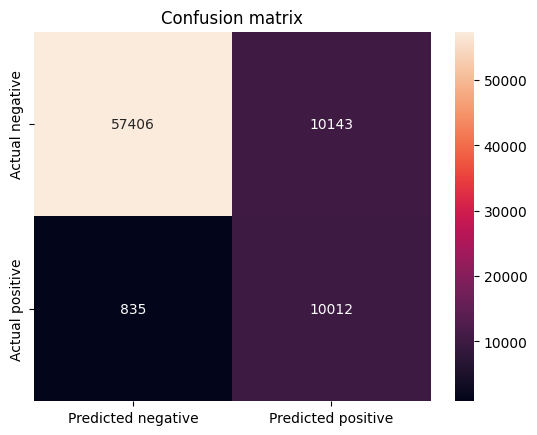

In [147]:
##evaluate the model on the original test set
evaluation_metric(mlp_smote, X_smote, y_smote, XX, yy)

Observe :

- Recall is at 92%, which is slightly worse than the case of undersampling
- Still, there is a significany improvement in reducing False Negatives, which is what we are trying to achieve

## Random Oversampling

In [148]:
from imblearn.over_sampling import RandomOverSampler

In [149]:
##create an instance of the model
ros = RandomOverSampler(random_state=42)

In [150]:
##transform the training data
X_ros, y_ros = ros.fit_resample(X, y)

In [151]:
##define the classifier model with the best parameters found by the hyperparameter search
mlp_ros = MLPClassifier(activation= 'relu', alpha= 0.01, learning_rate= 'constant', solver= 'adam', random_state=1923)  

In [152]:
##fit the model to the resampled data
mlp_ros.fit(X_ros, y_ros)

MLPClassifier(alpha=0.01, random_state=1923)

----------------------------------------------------------------------------------------------------
The mean cross validation score on the training set is: 0.8902288727842063
----------------------------------------------------------------------------------------------------
The mean cross validation score on the test set is: 0.9120108350438842
----------------------------------------------------------------------------------------------------
The difference between the mean cross validation scores on the training and test data: -0.02178196225967799


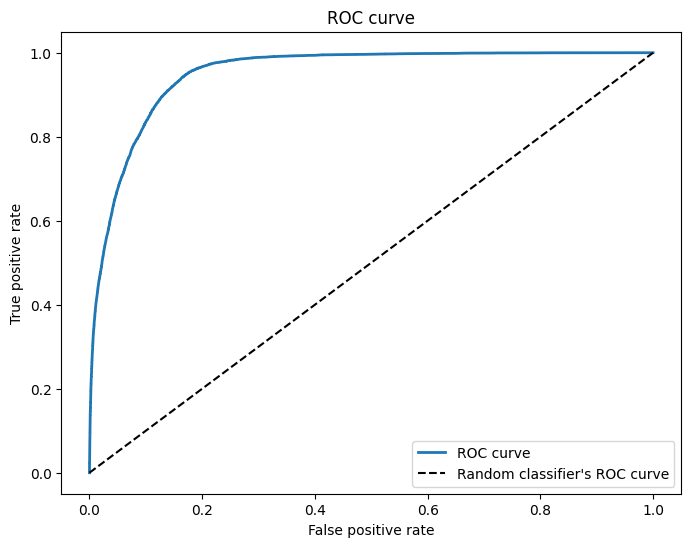

----------------------------------------------------------------------------------------------------
The AUC score is: 0.9507592829406174
----------------------------------------------------------------------------------------------------
The accuracy score is: 0.858053982346038
----------------------------------------------------------------------------------------------------
The true negative rate (TNR) is: 0.8470295637241114
----------------------------------------------------------------------------------------------------
The true positive rate (TPR) is: 0.9267078454872315
----------------------------------------------------------------------------------------------------
The recall score is: 0.9267078454872315
----------------------------------------------------------------------------------------------------


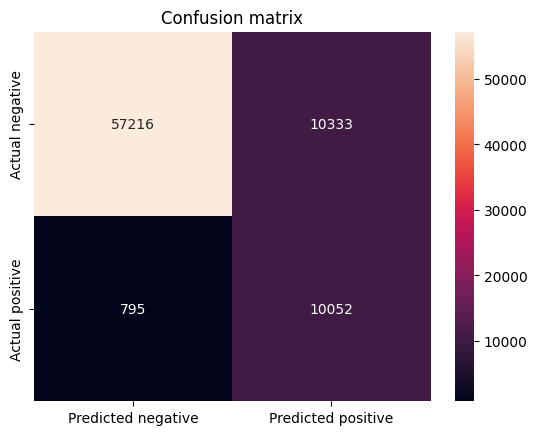

In [153]:
##evaluate the model on the original test set
evaluation_metric(mlp_ros, X_ros, y_ros, XX, yy)

<a id='section8_3'></a>
## Borderline-SMOTE1

In [154]:
from imblearn.over_sampling import BorderlineSMOTE

In [155]:
##create an instance of the model
bsmote = BorderlineSMOTE(random_state=42)

In [156]:
##transform the training data
X_bsmote, y_bsmote = bsmote.fit_resample(X, y)

In [157]:
##define the classifier model with the best parameters found by the hyperparameter search
mlp_bsmote = MLPClassifier(activation= 'relu', alpha= 0.01, learning_rate= 'constant', solver= 'adam', random_state=1923)

In [158]:
##fit the model to the resampled data
mlp_bsmote.fit(X_bsmote, y_bsmote)

MLPClassifier(alpha=0.01, random_state=1923)

----------------------------------------------------------------------------------------------------
The mean cross validation score on the training set is: 0.8673749841316427
----------------------------------------------------------------------------------------------------
The mean cross validation score on the test set is: 0.9120108350438842
----------------------------------------------------------------------------------------------------
The difference between the mean cross validation scores on the training and test data: -0.04463585091224154


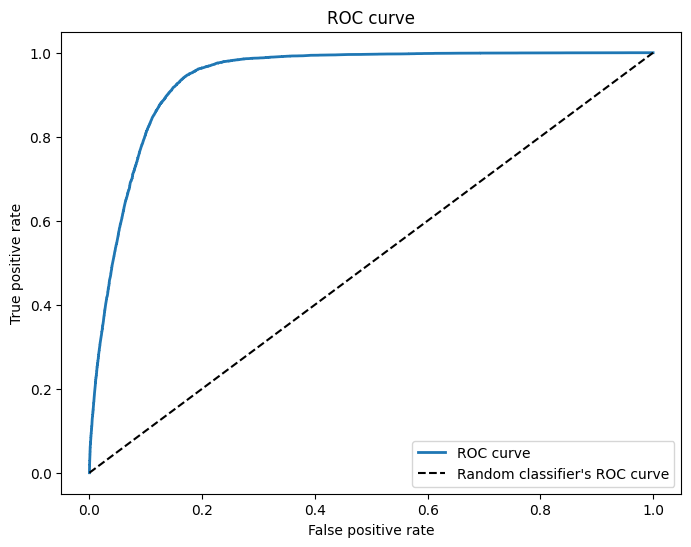

----------------------------------------------------------------------------------------------------
The AUC score is: 0.9389625669890055
----------------------------------------------------------------------------------------------------
The accuracy score is: 0.8358589723965508
----------------------------------------------------------------------------------------------------
The true negative rate (TNR) is: 0.8170217175679877
----------------------------------------------------------------------------------------------------
The true positive rate (TPR) is: 0.9531667742232875
----------------------------------------------------------------------------------------------------
The recall score is: 0.9531667742232875
----------------------------------------------------------------------------------------------------


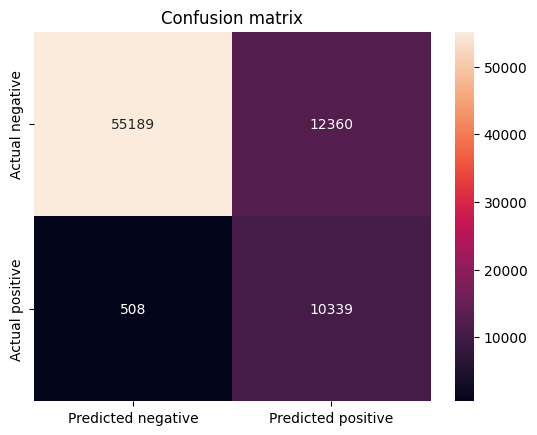

In [159]:
##evaluate the model on the original test set
evaluation_metric(mlp_bsmote, X_bsmote, y_bsmote, XX, yy)

Observe:

- In terms of recall, this is the best results so far, with recall going over 95%
- Notice the clear cost in FP, which have increases to over 12000


<a id='section9'></a>
# 9. Generalization Errors of Best Model

The aim of this section is to analyze the performance of the best model more thoroughly. As such, I will get the final predictions and calculate and interpret some performance metrics.

## <a id='section9_1'></a>Get Final Predictions 

In [160]:
final_predictions = mlp_bsmote.predict(XX) 

In [161]:
##these are the final predictions on the test set
final_predictions

array([1, 0, 1, ..., 0, 1, 0])

In [162]:
yy

439196    1
79519     0
402675    0
465637    1
515014    0
         ..
573811    0
21929     1
638509    0
41946     1
148142    0
Name: Higher_Risk, Length: 78396, dtype: int64

## <a id='section9_2'></a>MAE 

In [163]:
from scipy import stats

In [164]:
##let's set the confidence level to 95%
confidence = 0.95

In [165]:
##this is simply a vector of sqaured errors
sqr_errors = (final_predictions - yy)**2

In [166]:
##this is a vector containing the absolute errors
errors = np.abs(final_predictions - yy)

Let's calculate the confidence interval for the mean error

In [167]:
(stats.t.interval(confidence, len(errors)-1, loc=errors.mean(), scale=stats.sem(errors)))

(0.16154812805318045, 0.16673392715371785)

And the root mean squared error:

In [168]:
from sklearn.metrics import mean_absolute_error
mae = mean_absolute_error(yy, final_predictions)

In [169]:
mae

0.16414102760344915

Observe :

- The MAE simply reflects the accuracy of the classifier, which is actually quite bad due to many False Positives.

 <a id='section9_3'></a>
 ## Confusion Matrix

Let's also look at the confusion matrix for these final predictions with the MLP model

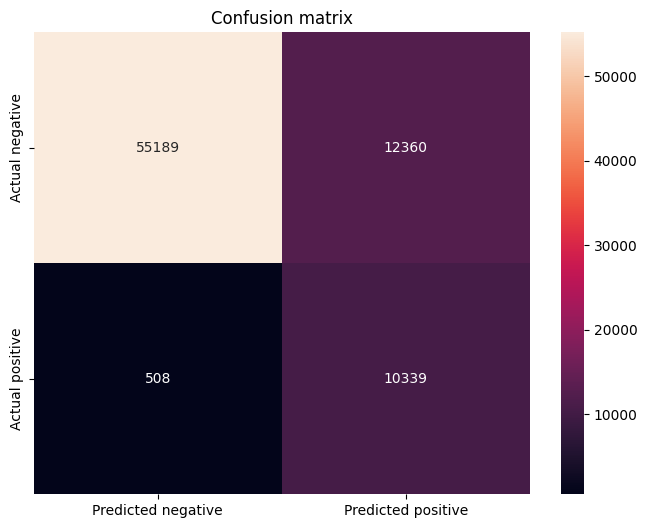

In [170]:
conf_mat = confusion_matrix (yy, final_predictions)
cm_df = pd.DataFrame(conf_mat, columns=["Predicted negative", "Predicted positive"], index=["Actual negative", "Actual positive"])
##plot the confusion matrix via seaborn

plt.figure(figsize=(8, 6))
sns.heatmap(cm_df, annot=True, fmt="d")
plt.title("Confusion matrix")
plt.show()


In [171]:
yy.value_counts()

Higher_Risk
0    67549
1    10847
Name: count, dtype: int64

In [172]:
len(yy)

78396

In [173]:
print("Imbalance in the test set", yy.value_counts()[1]/yy.value_counts()[0]*100)

Imbalance in the test set 16.057972730906453


As the test data on which we test the MLP is taken from the covid original data, it has over 67000 observations and the classes are imbalanced with with just over 16% of all cases being high risk. From the confusion matrix, the MLP model gave the best performance in terms of recall, when combined with the SMOTE Borderline method. Let's summarise the main points:

<ul>

- There are 10339 TP (true positives). This is the number of correct classified higher_risk covid patients. The false negatives (FN) represent the higher risk patients that were misclassified : 508. From the values in the confusion matrix, we can get the true positive rate with the usual formula : $TPR = TP / (TP +FN)$. If we insert the values from this confusion matrix the TPR turns out to be  96.93% which gives a pretty confidence in these predictions. The TPR can be interpreted as the probability of a positive prediction to be true. In this case, the model probability for each positive prediction to be correct is 95.31%.
- However, the model misclassifes many negative cases : 12360. This means that we get many more patients classified as high risk than they actually are.
- The true negative rate TNR can be calculated similarly to understand how confident we should be in the values of the majority class (lower risk). TNR for this model is over 81%, however, this is not a big problem given that the model gives high confidence in higher risk predictions (95%). Hence, the models correctly classifies almost all patients at high risk appropiately, the TNR simply suggests that there are many patients that are lower risk that will most likely be classified as high risk ( about 12000). Since getting more treatment than necessary is not harmful, the False Positives do not present a major problem.

</ul>

<p>
This model's strength is that it is very confidence in making predictions of the positive class, which is the minority class. Given that the ratio between minority class and majority class is close to 16:100, the model does a great job in offering high confidence predictions for the minority class ( covid high risk patients). This is very important, as the goal of the project was to find such a model, that predicts the minority class very well, to avoid misclassifying patients that are at high risk. 

</p>

 <a id='section9_4'></a>
 
 ## Accuracy

Let's also have a look at the accuracy of the model, which shows how many predictions (percetange wise) are correct. This metric is complementary to the TPR which is the most important for this case ( to predict well the minority class). However, accuracy can be useful too in understanding how the model performs. Since the test set contains highly imbalanced classes, we should get accuracy over 92% for the model to performs well by this metric. The reason for this is that around 92% of the data are 0's, so if a model would predict 0 all the time, it would be right 92% of the times. However, a model that predicts 0 all the time, is clearly not a good model.

In [174]:
##calculate accuracy directly from Scikit-Learn's accuracy_score method
accuracy_score(yy, final_predictions)

0.8358589723965508

The accuracy is clearly not very good, but as said before, the more important metric is TPR which is over 96%. To test the calculation above, it is simply to calculate the accuracy directly from the confusion matrix. It is the sum of true values (main diagonal) over all values.

In [175]:
true_predictions = conf_mat[0][0] + conf_mat[1][1]
print ("The number of true predictions is", true_predictions)

The number of true predictions is 65528


In [176]:
accuracy_hand = true_predictions/len(yy)
print ("The accuracy calculated by hand is", accuracy_hand)

The accuracy calculated by hand is 0.8358589723965508


Clearly this calculation seems to be correct. Hence, we have a model that predicts correctly 85% of the time, but when it predicts a high risk covid patient, there is over 96% probability that the prediction is correct. Tthe confidence in the negative predictions are lower, with a true negative rate of 84.6%

 <a id='section10'></a> 
# 10. Launch

Now that we have our best model, let us save it for further use. I will use joblib to do it.

In [177]:
import joblib

In [178]:
joblib.dump(mlp_clf, "MultiLayer_Perceptron_Classifier_Covid .pkl")

['MultiLayer_Perceptron_Classifier_Covid .pkl']

For further use, let us also save the preprocessing pipeline

In [179]:
preprocessing

ColumnTransformer(remainder='passthrough',
                  transformers=[('bucket_pipeline_1',
                                 Pipeline(steps=[('kbinsdiscretizer',
                                                  KBinsDiscretizer(encode='ordinal',
                                                                   n_bins=2,
                                                                   random_state=1923,
                                                                   strategy='kmeans')),
                                                 ('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'))]),
                                 ['MEDICAL_UNIT']),
                                ('categorical',
                                 Pipeline(steps=[('customtransformer',
                                                  CustomTransformer()),
                                                 ('oneh...
                                  'DIABETES', 'COPD', 'ASTHMA', 'INMSUPR',
                                  'HIPERTENSION', 'OTHER_DISEASE',
                                  'CARDIOVASCULAR', 'OBESITY', 'RENAL_CHRONIC',
                                  'TOBACCO', 'ICU']),
                                ('numerical',
                                 Pipeline(steps=[('standardscaler',
                                                  StandardScaler())]),
                                 ['AGE']),
                                ('categorical simple',
                                 Pipeline(steps=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'))]),
                                 ['SEX', 'PATIENT_TYPE']),
                                ('drop_age', 'drop',
                                 ['CLASIFFICATION_FINAL', 'Higher_Risk'])])

In [180]:
joblib.dump(preprocessing, "preprocessing.pkl")

['preprocessing.pkl']